# **Text Mining Group Project**
**Master's  Degree Program in Data Science and Advanced Analytics, with specialization in Data Science (A.Y. 2023/2024)**<br/>
**NOVA IMS**<br/>


### **Group Information**

*   Diogo Barros, 20230555 
*   Diogo Roiçado, 20230557 
*   Pedro Guedes, 20230569
*   Rodrigo Rocha, 20230593

## <a class="anchor" id="index">Index<br>

[<font color='#E8800A'>1 - Import Libraries</font>](#topic01) <br>
[<font color='#E8800A'>2 - Import the datasets</font>](#topic02) <br>
[<font color='#E8800A'>3 - Define functions to handle data</font>](#topic03) <br>
[<font color='#E8800A'>4 - Data Exploration</font>](#topic04) <br>
[<font color='#E8800A'>5 - Data Preprocessing</font>](#topic05) <br>
[<font color='#E8800A'>6 - Feature Engineering</font>](#topic06) <br>
[<font color='#E8800A'>7 - Classification Models</font>](#topic07) <br>
[<font color='#E8800A'>8 - Grid Search</font>](#topic08) <br>
[<font color='#E8800A'>9 - Evaluation on Test Set</font>](#topic09) <br>

<a class="anchor" id="topic01" /><br>
## 1. Import Libraries
[Back to Index](#index)

##### 1.1 Import needed libraries

In [170]:
import pandas as pd
import numpy as np
from numpy import mean,  std
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import ceil
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torchtext.vocab as vocab
from collections import Counter
import string
import contractions
from sentence_transformers import SentenceTransformer
#out of classes options
import spacy
#Glove
import gensim
import gensim.downloader as api

# Preprocessing and Feature Extraction
from bs4 import BeautifulSoup #remove html tags
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

# NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
# Classifiers
from sklearn.model_selection import GridSearchCV, StratifiedKFold #for hyperparameter optimization
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, ComplementNB, CategoricalNB

# Pipeline and ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_predict

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from tensorflow.keras import Input, layers
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Masking, Dropout
from tensorflow.keras.metrics import Metric

# Evaluation metrics
from keras import backend as K
from keras.metrics import Precision, Recall

# Detect language
from langdetect import detect

# Warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Rodrigo
[nltk_data]     Rocha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rodrigo
[nltk_data]     Rocha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Rodrigo
[nltk_data]     Rocha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##### 1.2 Define global variables that will control execution options throughout the notebook

In [7]:
g_verbose_mode = True
g_verbose_models = 3
g_random_state = 53

target_var = "unlisted"
labels = {"Listed":0, "Unlisted":1}

lstvars_targets = [target_var]

dicParams = {}

dicParams["validation_size"] = 0.20

dicParams["StratifiedKFold_n_splits"] = 3

SKfold = StratifiedKFold(n_splits=dicParams["StratifiedKFold_n_splits"], 
                               shuffle=True, 
                               random_state=g_random_state)


<a class="anchor" id="topic02" /><br>
## 2. Import the Datasets
[Back to Index](#index)

In [8]:
airbnb_df_train = pd.read_excel('./Project Corpora/train.xlsx').set_index('index')
print(f"Train total properties: {len(airbnb_df_train)}")
airbnb_df_train.head()

Train total properties: 6248


,description,host_about,unlisted
index,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [9]:
airbnb_df_test = pd.read_excel('./Project Corpora/test.xlsx').set_index('index')
print(f"Test total properties: {len(airbnb_df_test)}")
airbnb_df_test.head()

Test total properties: 695


,description,host_about
index,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
4,Charming Apartment Close to the Bay of Cascais...,:)
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


In [10]:
airbnb_train_reviews = pd.read_excel('./Project Corpora/train_reviews.xlsx')
print(f"Train total reviews: {len(airbnb_train_reviews)}")
airbnb_train_reviews.head()

Train total reviews: 361281


,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [11]:
airbnb_test_reviews = pd.read_excel('./Project Corpora/test_reviews.xlsx')
print(f"Test total reviews: {len(airbnb_test_reviews)}")
airbnb_test_reviews.head()

Test total reviews: 41866


,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


<br><a class="anchor" id="topic03" /><br>
## 3. Define functions to handle data
Define generic functions as a way to organize code and simplify more complex blocks of code<br>
<br> [Back to Index](#index)

In [12]:
def detect_language(text):
    try:
        return detect(text) if isinstance(text, str) else None
    except:
        return None

In [13]:
def average_words(x):
    words = x.split()
    if len(words) == 0:
        return 0
    else:
        return sum(len(word) for word in words) / len(words)

In [14]:
def create_stopwords(language):
    if language == 'en':
        return set(stopwords.words('english'))
    elif language == 'pt':
        return set(stopwords.words('portuguese'))
    elif language == 'fr':
        return set(stopwords.words('french'))
    elif language == 'es':
        return set(stopwords.words('spanish'))
    elif language == 'de':
        return set(stopwords.words('german'))
    elif language == 'it':
        return set(stopwords.words('italian'))
    elif language == 'ca':
        return set(stopwords.words('catalan'))
    elif language == 'nl':
        return set(stopwords.words('dutch'))
    elif language == 'no':
        return set(stopwords.words('norwegian'))
    elif language == 'sv':
        return set(stopwords.words('swedish'))
    elif language == 'tr':
        return set(stopwords.words('turkish'))
    elif language == 'he':
        return set(stopwords.words('hebrew'))
    elif language == 'id':
        return set(stopwords.words('indonesian'))
    else:
        return set()


#### 3.1 Functions to test the performance of our models

In [15]:
# Define a function to train, predict, and calculate metrics
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = round(f1_score(y_train, y_train_pred, average='weighted'), 3)
    train_precision = round(precision_score(y_train, y_train_pred, average='weighted'), 3)
    train_recall = round(recall_score(y_train, y_train_pred, average='weighted'), 3)
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = round(f1_score(y_val, y_val_pred, average='weighted'), 3)
    val_precision = round(precision_score(y_val, y_val_pred, average='weighted'), 3)
    val_recall = round(recall_score(y_val, y_val_pred, average='weighted'), 3)
    
    return {
        'Model': model_name,
        'Train Accuracy': train_accuracy,
        'Train F1': train_f1,
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Validation Accuracy': val_accuracy,
        'Validation F1': val_f1,
        'Validation Precision': val_precision,
        'Validation Recall': val_recall
    }

In [16]:
def plot_cm(confusion_matrix : np.array,
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis.
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes

    Returns:
        - Plot of the Confusion Matrix
    """

    confusionmatrix = confusion_matrix
    class_names = classnames

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()


<a class="anchor" id="topic04" /><br>
## 4. Data Exploration
[Back to Index](#index)


### 4.1 Data Type Analysis

In [17]:
airbnb_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6248 entries, 1 to 6248
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  6248 non-null   object
 1   host_about   6248 non-null   object
 2   unlisted     6248 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 195.2+ KB


In [18]:
airbnb_df_train['description'][1]

'This is a shared mixed room in our hostel, with shared bathroom.<br />We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.<br /><br /><b>The space</b><br />We offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and  There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 and we have a late check out at 11:00, so you can sleep until late!<br /><br /><b>Guest access</b><br />All rooms have key-card access.'

In [19]:
airbnb_train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     361281 non-null  int64 
 1   comments  361279 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


In [20]:
airbnb_train_reviews['comments'][10]

'Well located and clean.'

In [21]:
# Identify rows where 'description' is not a string
non_string_descriptions = airbnb_df_train[~airbnb_df_train['description'].apply(isinstance, args=(str,))]
print("Rows where 'description' is not a string:")
print(non_string_descriptions.head(10))

# Identify rows where 'host_about' is not a string
non_string_host_about = airbnb_df_train[~airbnb_df_train['host_about'].apply(isinstance, args=(str,))]
print("Rows where 'host_about' is not a string:")
print(non_string_host_about.head(10))

Rows where 'description' is not a string:
Empty DataFrame
Columns: [description, host_about, unlisted]
Index: []


Rows where 'host_about' is not a string:
Empty DataFrame
Columns: [description, host_about, unlisted]
Index: []


The data types are correct

### 4.2 Target variable

In [22]:
(airbnb_df_train['unlisted']).unique()

array([0, 1], dtype=int64)

In [23]:
# we have unbalanced data
airbnb_df_train['unlisted'].value_counts()

unlisted
0    4540
1    1708
Name: count, dtype: int64

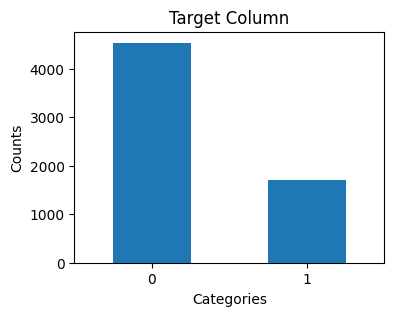

In [24]:
plt.figure(figsize=(4,3))
airbnb_df_train['unlisted'].value_counts().plot(kind='bar')
plt.title('Target Column')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

### 4.3 Missing values

In [25]:
# We don´t have missing values 
print("Missing values in the description column: " + str(airbnb_df_train['description'].isna().sum()))
print("Missing values in the description column: " + str(airbnb_df_train['host_about'].isna().sum()))
print("Missing values in the comments column: " + str(airbnb_train_reviews['comments'].isna().sum()))

Missing values in the description column: 0
Missing values in the description column: 0
Missing values in the comments column: 2


In [26]:
airbnb_train_reviews.dropna(subset=['comments'], inplace=True)
print("Missing values in the comments column: " + str(airbnb_train_reviews['comments'].isna().sum()))

Missing values in the comments column: 0


### 4.4 Duplicated rows

In [27]:
import pandas as pd

# Group the dataframe by 'description' and 'host_about' and count the occurrences
grouped = airbnb_df_train.groupby(['description', 'host_about']).size().reset_index(name='counts')

# Filter for rows that are repeated exactly 5 times
repeated_five_times = grouped[grouped['counts'] == 6]

# Merge with the original dataframe to get the repeated rows
repeated_rows = pd.merge(repeated_five_times[['description', 'host_about']], airbnb_df_train, on=['description', 'host_about'], how='inner')

# Print the repeated rows
repeated_rows.head(20)


,description,host_about,unlisted
0,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
1,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
2,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
3,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
4,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
5,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
6,We are The Salty Pelican Yoga & Surf Retreat. ...,Hello… We are The Salty Pelican Surf & Yoga Re...,0
7,We are The Salty Pelican Yoga & Surf Retreat. ...,Hello… We are The Salty Pelican Surf & Yoga Re...,0
8,We are The Salty Pelican Yoga & Surf Retreat. ...,Hello… We are The Salty Pelican Surf & Yoga Re...,0
9,We are The Salty Pelican Yoga & Surf Retreat. ...,Hello… We are The Salty Pelican Surf & Yoga Re...,0


In [28]:
# We have duplicated rows in both dataframes
print("Duplicated values in airbnb_df_train: " + str(airbnb_df_train.duplicated().sum()))
print("Duplicated values in airbnb_train_reviews: " + str(airbnb_train_reviews.duplicated().sum()))

Duplicated values in airbnb_df_train: 192
Duplicated values in airbnb_train_reviews: 142


### 4.5 Description column language analyse

In [29]:
df_description =  airbnb_df_train[['description', 'unlisted']].copy()
df_description.head()

,description,unlisted
index,,
1,"This is a shared mixed room in our hostel, wit...",0
2,"O meu espaço fica perto de Parque Eduardo VII,...",1
3,Trafaria’s House is a cozy and familiar villa ...,1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",0
5,Joli appartement en bordure de mer.<br /> 2 m...,0


In [30]:
df_description['language_d'] = df_description['description'].apply(detect_language)
df_description['language_d'].value_counts()

language_d
en       5111
pt        905
fr         83
da         59
de         45
es         28
it          4
no          3
ca          3
zh-cn       3
sv          2
nl          2
Name: count, dtype: int64

en: English
pt: Portuguese
fr: French
da: Danish
de: German
es: Spanish
no: Norwegian
it: Italian
ca: Catalan
zh-cn: Chinese (Simplified)
nl: Dutch
sv: Swedish

#### 4.5.1 Stopwords per language

In [31]:
languages_description = df_description['language_d'].unique()

# Create stop words for each language
stopwords_by_language_description = {lang: create_stopwords(lang) for lang in languages_description}

print(stopwords_by_language_description['en'])

{'hasn', 'were', 'than', 'will', 'above', 'where', 'herself', "hasn't", 'y', 's', "you've", 'up', 'itself', 'me', 'ourselves', 'more', 'haven', 'needn', 'mightn', "needn't", 'll', 'do', "that'll", "should've", 'should', 'his', 'against', 'doesn', 'of', 'when', "wasn't", 'what', 'have', 'and', 'to', 'while', 'be', 'an', 'we', 'she', 'so', 'few', 'that', 'those', 'but', 'm', 'shouldn', "wouldn't", 'whom', 'by', 'he', 'further', 'very', 'hers', 'hadn', 'myself', "haven't", 'these', "isn't", "doesn't", 'weren', 'which', 'won', 'this', 'being', 'was', "you're", 'can', 'them', 'before', 'theirs', 'some', 'their', 'ma', 'are', "shouldn't", 'has', 'such', 'most', 're', 'd', 'on', 'shan', "aren't", "weren't", 'there', 'all', 'why', 'not', "hadn't", 'just', 'ain', 'nor', 'in', 'through', 'too', 'until', 'with', "mustn't", 'did', 'over', 'now', 'a', 'out', 'its', 'wasn', 'i', 'had', 'our', 'only', 'your', 'my', 'or', 'having', "couldn't", 'after', "don't", 'you', 'been', 'both', 'from', 'at', 'in

#### 4.5.2 Wrongly Classified Sentences

In [32]:
# Ensure all rows will be displayed
pd.set_option('display.max_rows', None)

# Filter the dataframe to exclude the specified languages
df_description[~df_description['language_d'].isin(['en','pt','fr','es','da','de'])]

,description,unlisted,language_d
index,,,
324,Lys og flott leilighet i vakre omgivelser. Gåa...,1,no
634,Furnaka Village<br /><br /><b>License number</...,0,sv
657,Swallow Hostel sinta-se em casa!,0,it
1966,Nunca irá esquecer esta escapadela única e rom...,1,ca
2271,Apartment is between “Alameda subway” and “Anj...,0,zh-cn
2293,Swallow Hostel 6 sinta-se em casa!,0,it
2410,Golden Beach Apartment “迷人而精致的公寓，位于Cascais 的中心...,0,zh-cn
2967,Välkommen till vårt (Felix & Mollys) fantastis...,1,sv
2988,这是位于葡萄牙里斯本辛特拉的独栋私人别墅，位于著名度假胜地辛特拉高尔夫酒店的正对面，拥有里斯...,1,zh-cn


In [33]:
df_description.loc[634, 'language_d'] = 'en'
df_description.loc[657, 'language_d'] = 'pt'
df_description.loc[1785, 'language_d'] = 'pt'
df_description.loc[1966, 'language_d'] = 'pt'
df_description.loc[2271, 'language_d'] = 'en'
df_description.loc[2293, 'language_d'] = 'pt'
df_description.loc[3252, 'language_d'] = 'pt'
df_description.loc[3375, 'language_d'] = 'zh-cn'
df_description.loc[3543, 'language_d'] = 'zh-cn'
df_description.loc[4946, 'language_d'] = 'zh-cn'
df_description.loc[5019, 'language_d'] = 'pt'

In [34]:
df_description[df_description['language_d'].isin(['da'])].head(10)

,description,unlisted,language_d
index,,,
282,<b>License number</b><br />43084/AL,0,da
481,入住独一无二的房源，感受市中心的律动。<br /><br /><b>License numb...,1,da
654,<b>License number</b><br />37710/AL,1,da
714,<b>License number</b><br />92019/AL,1,da
1061,<b>License number</b><br />121300/AL,0,da
1093,<b>License number</b><br />76774/AL,1,da
1236,<b>License number</b><br />121745/AL,1,da
1300,<b>License number</b><br />9996004475162,0,da
1325,<b>License number</b><br />126305/AL,1,da


#### The majority of the Danish descriptions are wrongly assigned, they have the following format: "< b>License number</ b ><br />xxxxx/AL". We will deal with this problem later.

#### The main languages from this column are: <b>english, portuguese, french, deutsch and spanish.<b>

#### 4.5.3 Correction

In [35]:
df_description['language_d'].value_counts()

language_d
en       5112
pt        911
fr         83
da         58
de         45
es         28
zh-cn       5
it          2
nl          2
no          1
sv          1
Name: count, dtype: int64

### 4.6 Description Analysis

In [36]:
df_description['word_count'] = df_description['description'].apply(lambda x: len(x.split()))
df_description['char_count'] = df_description['description'].apply(lambda x: len(x))
df_description['average_word_lenght'] = df_description['description'].apply(lambda x: average_words(x))
df_description['stopwords_count'] = df_description.apply(lambda row: len([word for word in str(row['description']).split() if word.lower() in stopwords_by_language_description[row['language_d']]]), axis=1)
df_description['stopword_ratio'] = df_description['stopwords_count'] / df_description['word_count']
df_description.head(10)

,description,unlisted,language_d,word_count,char_count,average_word_lenght,stopwords_count,stopword_ratio
index,,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",0,en,126,729,4.785714,48,0.380952
2,"O meu espaço fica perto de Parque Eduardo VII,...",1,pt,23,138,5.043478,7,0.304348
3,Trafaria’s House is a cozy and familiar villa ...,1,en,167,1000,4.976048,50,0.299401
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",0,pt,47,272,4.808511,18,0.382979
5,Joli appartement en bordure de mer.<br /> 2 m...,0,fr,96,659,5.822917,16,0.166667
6,"IMPORTANT: In response to COVID-19, this prope...",0,en,145,1000,5.896552,41,0.282759
7,This is my home that I rent out when I'm trave...,1,en,138,789,4.717391,46,0.333333
8,Find tranquility in this meticulously curated ...,0,en,94,656,5.989362,28,0.297872
9,Charming apartment with one bedroom with doubl...,0,en,145,869,4.986207,48,0.331034


In [37]:
df_description.describe()

,unlisted,word_count,char_count,average_word_lenght,stopwords_count,stopword_ratio
count,6248.000000,6248.000000,6248.000000,6248.000000,6248.000000,6248.000000
mean,0.273367,132.119878,816.135083,5.365817,46.843470,0.341662
std,0.445724,47.742357,280.150662,0.926862,20.396859,0.081770
min,0.000000,3.000000,12.000000,3.333333,0.000000,0.000000
25%,0.000000,99.000000,629.750000,4.946429,32.000000,0.306540
50%,0.000000,156.000000,1000.000000,5.205882,51.000000,0.354037
75%,1.000000,166.000000,1000.000000,5.523260,62.000000,0.393939
max,1.000000,196.000000,1000.000000,21.000000,99.000000,0.588235


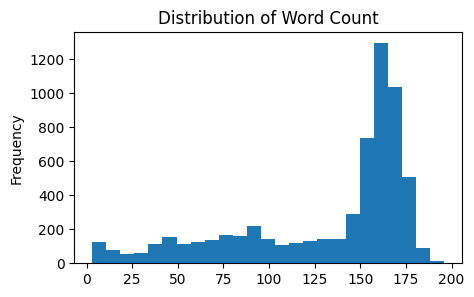

In [38]:
plt.figure(figsize=(5,3))
df_description['word_count'].hist(bins=25)
plt.grid(False)  
plt.title('Distribution of Word Count')
plt.ylabel('Frequency')
plt.show()

In [39]:
df_description['unlisted'][df_description['word_count'] > 150].value_counts()

unlisted
0    2800
1     811
Name: count, dtype: int64

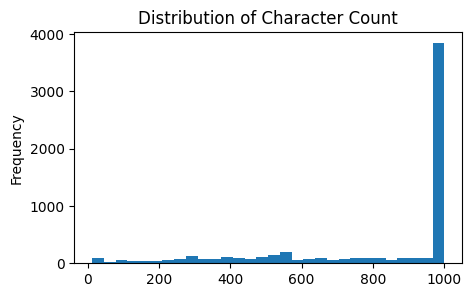

In [40]:
plt.figure(figsize=(5,3))
df_description['char_count'].hist(bins=30)
plt.grid(False)  
plt.title('Distribution of Character Count')
plt.ylabel('Frequency')
plt.show()

In [41]:
df_description['unlisted'][df_description['char_count'] > 950].value_counts()

unlisted
0    2976
1     915
Name: count, dtype: int64

In [42]:
all_words_description_column = ' '.join(df_description['description']).split()
freq_description_column = pd.Series(all_words_description_column).value_counts().sort_values(ascending=False)
freq_description_column.head(10)

the      31323
and      27698
a        25540
/><br    17380
to       15328
of       15122
in       13866
with     13649
is       12083
de        6918
Name: count, dtype: int64

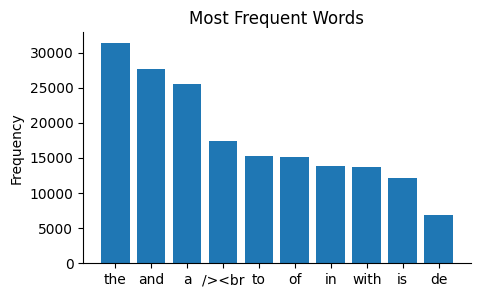

In [43]:
plt.figure(figsize=(5,3))
plt.grid(False)
plt.bar(freq_description_column.index[0:10], freq_description_column[:10])
plt.xticks(freq_description_column.index[0:10])
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

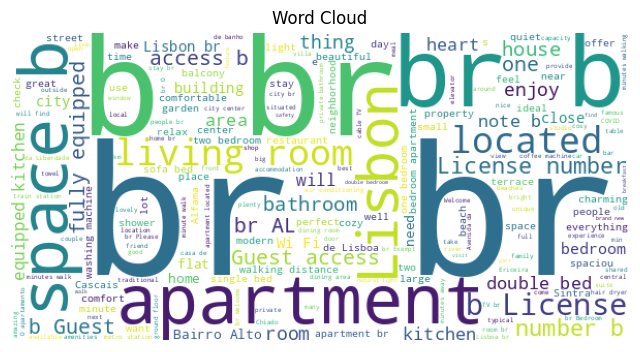

In [44]:
# Joining all the descriptions into a single string
all_descriptions = ' '.join(df_description['description'])
    
# Create WordCloud object
wordcloud = WordCloud(width=600, height=300, background_color="white").generate(all_descriptions)

#Plotting the word cloud
plt.figure(figsize=(8,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

### 4.7 Host_about column Analyses

In [45]:
df_host_about =  airbnb_df_train[['host_about', 'unlisted']].copy()
df_host_about.head()

,host_about,unlisted
index,,
1,Alojamento Local Registro: 20835/AL,0
2,"I am friendly host, and I will try to always b...",1
3,"I am a social person liking to communicate, re...",1
4,Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Nous sommes une famille avec deux enfants de 1...,0


In [46]:
df_host_about['language_ha'] = df_host_about['host_about'].apply(detect_language)
df_host_about['language_ha'].value_counts()

language_ha
en       4445
pt       1265
fr        137
es         84
de         53
it         44
ca         41
zh-cn      28
so         15
no         11
nl          9
af          8
fi          7
id          4
sw          3
sk          3
et          3
zh-tw       3
tl          3
sv          3
da          2
ro          2
tr          2
lt          1
sl          1
he          1
vi          1
hr          1
ru          1
Name: count, dtype: int64

#### 4.7.1 Host About Stopwords

In [47]:
languages_host_about = df_host_about['language_ha'].unique()

# Create stop words for each language
stopwords_by_language_host_about = {lang: create_stopwords(lang) for lang in languages_host_about}

print(stopwords_by_language_host_about['en'])

{'hasn', 'were', 'than', 'will', 'above', 'where', 'herself', "hasn't", 'y', 's', "you've", 'up', 'itself', 'me', 'ourselves', 'more', 'haven', 'needn', 'mightn', "needn't", 'll', 'do', "that'll", "should've", 'should', 'his', 'against', 'doesn', 'of', 'when', "wasn't", 'what', 'have', 'and', 'to', 'while', 'be', 'an', 'we', 'she', 'so', 'few', 'that', 'those', 'but', 'm', 'shouldn', "wouldn't", 'whom', 'by', 'he', 'further', 'very', 'hers', 'hadn', 'myself', "haven't", 'these', "isn't", "doesn't", 'weren', 'which', 'won', 'this', 'being', 'was', "you're", 'can', 'them', 'before', 'theirs', 'some', 'their', 'ma', 'are', "shouldn't", 'has', 'such', 'most', 're', 'd', 'on', 'shan', "aren't", "weren't", 'there', 'all', 'why', 'not', "hadn't", 'just', 'ain', 'nor', 'in', 'through', 'too', 'until', 'with', "mustn't", 'did', 'over', 'now', 'a', 'out', 'its', 'wasn', 'i', 'had', 'our', 'only', 'your', 'my', 'or', 'having', "couldn't", 'after', "don't", 'you', 'been', 'both', 'from', 'at', 'in

#### 4.7.2 Missclassified Languages in Host_About sentences

In [48]:
# Ensure all rows will be displayed
pd.set_option('display.max_rows', None)

# Filter the dataframe to exclude the specified languages
df_host_about[df_host_about['language_ha'].isin(['so','no','nl','af','fi','sv','ro','tl','sk','zh-tw','sw','id','ru','et','da','lt','tr,','sl',',he,','vi,hr'])]

,host_about,unlisted,language_ha
index,,,
111,_x000D_\n,0,so
194,@ZMPoppe\n,1,nl
324,Jeg og min portugisiske ektemann kjøpte sommer...,1,no
373,s,0,sv
380,"Enthousiast, open en warm en altijd vol ideeën...",1,nl
477,Dalma,0,so
515,Alfama,0,sw
689,欢迎各位，很開心你們分享我的房源。我們會盡力的協助你們在里斯本有個開心快樂的假期。,0,zh-tw
778,_x000D_\n,0,so


In [49]:
df_host_about.loc[111, 'language_ha'] = 'unknown'
df_host_about.loc[194, 'language_ha'] = 'unknown'
df_host_about.loc[373, 'language_ha'] = 'unknown'
df_host_about.loc[458, 'language_ha'] = 'en'
df_host_about.loc[477, 'language_ha'] = 'unknown'
df_host_about.loc[515, 'language_ha'] = 'pt'  # or 'pt'
df_host_about.loc[778, 'language_ha'] = 'unknown'
df_host_about.loc[808, 'language_ha'] = 'unknown'
df_host_about.loc[894, 'language_ha'] = 'unknown'
df_host_about.loc[943, 'language_ha'] = 'en'
df_host_about.loc[1020, 'language_ha'] = 'en'
df_host_about.loc[1074, 'language_ha'] = 'unknown'
df_host_about.loc[1332, 'language_ha'] = 'unknown'
df_host_about.loc[1404, 'language_ha'] = 'unknown'
df_host_about.loc[1627, 'language_ha'] = 'la'  # or 'la'
df_host_about.loc[1636, 'language_ha'] = 'unknown'
df_host_about.loc[1777, 'language_ha'] = 'unknown'
df_host_about.loc[1884, 'language_ha'] = 'unknown'
df_host_about.loc[2015, 'language_ha'] = 'unknown'
df_host_about.loc[2077, 'language_ha'] = 'pt'
df_host_about.loc[2084, 'language_ha'] = 'en'
df_host_about.loc[2182, 'language_ha'] = 'pt'
df_host_about.loc[2205, 'language_ha'] = 'pt'
df_host_about.loc[2226, 'language_ha'] = 'en'
df_host_about.loc[2362, 'language_ha'] = 'en'
df_host_about.loc[2372, 'language_ha'] = 'en'
df_host_about.loc[2482, 'language_ha'] = 'pt'  # or 'unknown'
df_host_about.loc[2662, 'language_ha'] = 'unknown'
df_host_about.loc[2709, 'language_ha'] = 'unknown'
df_host_about.loc[2712, 'language_ha'] = 'en'
df_host_about.loc[2738, 'language_ha'] = 'en'
df_host_about.loc[2888, 'language_ha'] = 'unknown'
df_host_about.loc[2982, 'language_ha'] = 'unknown'
df_host_about.loc[3159, 'language_ha'] = 'en'
df_host_about.loc[3255, 'language_ha'] = 'en'
df_host_about.loc[3306, 'language_ha'] = 'pt'
df_host_about.loc[3388, 'language_ha'] = 'en'
df_host_about.loc[3401, 'language_ha'] = 'unknown'
df_host_about.loc[3451, 'language_ha'] = 'en'
df_host_about.loc[3479, 'language_ha'] = 'en'
df_host_about.loc[3699, 'language_ha'] = 'unknown'
df_host_about.loc[3766, 'language_ha'] = 'unknown'
df_host_about.loc[3769, 'language_ha'] = 'pt'
df_host_about.loc[3822, 'language_ha'] = 'en'
df_host_about.loc[4058, 'language_ha'] = 'en'
df_host_about.loc[4219, 'language_ha'] = 'unknown'
df_host_about.loc[4256, 'language_ha'] = 'unknown'
df_host_about.loc[4301, 'language_ha'] = 'en'
df_host_about.loc[4328, 'language_ha'] = 'unknown'
df_host_about.loc[4374, 'language_ha'] = 'en'
df_host_about.loc[4509, 'language_ha'] = 'unknown'
df_host_about.loc[4543, 'language_ha'] = 'en'
df_host_about.loc[4572, 'language_ha'] = 'unknown'
df_host_about.loc[4636, 'language_ha'] = 'en'
df_host_about.loc[4977, 'language_ha'] = 'unknown'
df_host_about.loc[5035, 'language_ha'] = 'en'
df_host_about.loc[5075, 'language_ha'] = 'en'
df_host_about.loc[5104, 'language_ha'] = 'unknown'
df_host_about.loc[5150, 'language_ha'] = 'en'
df_host_about.loc[5227, 'language_ha'] = 'pt'
df_host_about.loc[5307, 'language_ha'] = 'en'
df_host_about.loc[5683, 'language_ha'] = 'unknown'
df_host_about.loc[5740, 'language_ha'] = 'unknown'
df_host_about.loc[5883, 'language_ha'] = 'en'
df_host_about.loc[5911, 'language_ha'] = 'en'
df_host_about.loc[5966, 'language_ha'] = 'unknown'
df_host_about.loc[5984, 'language_ha'] = 'unknown'
df_host_about.loc[6012, 'language_ha'] = 'pt'

In [50]:
df_host_about['language_ha'].value_counts()

language_ha
en         4468
pt         1274
fr          136
es           84
de           52
it           44
ca           40
unknown      32
zh-cn        28
nl            5
zh-tw         3
sv            2
af            2
et            2
id            2
no            1
da            1
la            1
tr            1
he            1
vi            1
hr            1
Name: count, dtype: int64

#### 4.7.3 Language Analysis

In [51]:
# Filter the dataframe to exclude the specified languages
aux_df = df_host_about[~df_host_about['language_ha'].isin(['en','pt','fr','es','de','it','ca'])]
aux_df['unlisted'].value_counts()

unlisted
0    103
1     47
Name: count, dtype: int64

In [52]:
pd.reset_option('display.max_rows', None)

In [53]:
df_host_about[df_host_about['language_ha'].isna()].head(10)

,host_about,unlisted,language_ha
index,,,
19,,0,None
86,\n\n,0,None
93,.,1,None
186,.,0,None
375,-,0,None
463,...,1,None
585,:),0,None
635,...,1,None
651,...,0,None


In [54]:
df_host_about['unlisted'][df_host_about['language_ha'].isna()].value_counts()

unlisted
0    49
1    18
Name: count, dtype: int64

#### 4.8 Host_About analyses 

In [55]:
df_host_about['word_count'] = df_host_about['host_about'].apply(lambda x: len(x.split()))
df_host_about['char_count'] = df_host_about['host_about'].apply(lambda x: len(x))
df_host_about['average_word_lenght'] = df_host_about['host_about'].apply(lambda x: average_words(x))
df_host_about['stopwords_count'] = df_host_about.apply(lambda row: 0 if row['language_ha'] == 'unknown' else len([word for word in str(row['host_about']).split() if word.lower() in stopwords_by_language_host_about.get(row['language_ha'], [])]), axis=1)
df_host_about['stopword_rate'] = df_host_about['stopwords_count'] / df_host_about['word_count']
df_host_about.head(10)

,host_about,unlisted,language_ha,word_count,char_count,average_word_lenght,stopwords_count,stopword_rate
index,,,,,,,,
1,Alojamento Local Registro: 20835/AL,0,pt,4,35,8.000000,0,0.000000
2,"I am friendly host, and I will try to always b...",1,en,24,123,4.166667,11,0.458333
3,"I am a social person liking to communicate, re...",1,en,43,235,4.441860,20,0.465116
4,Hello!_x000D_\nI m Portuguese and i love to me...,0,en,32,162,4.093750,15,0.468750
5,Nous sommes une famille avec deux enfants de 1...,0,fr,36,224,5.222222,16,0.444444
6,"Hi, we are Homing - a company that develops it...",0,en,97,572,4.907216,40,0.412371
7,Globe trotter. I'm of Portuguese nationality w...,1,en,37,229,5.216216,11,0.297297
8,I travel a lot and I love it. _x000D_\nOrigina...,0,en,94,512,4.446809,40,0.425532
9,"Isabel & Helder, portugueses, parents of three...",0,en,33,207,5.303030,10,0.303030


In [56]:
df_host_about.describe()

,unlisted,word_count,char_count,average_word_lenght,stopwords_count,stopword_rate
count,6248.000000,6248.000000,6248.000000,6248.000000,6248.000000,6224.000000
mean,0.273367,75.194942,444.008163,5.090609,31.044974,0.398459
std,0.445724,81.384186,505.223612,2.699575,29.777711,0.127179
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,26.000000,151.000000,4.448049,11.000000,0.368421
50%,0.000000,56.000000,325.000000,4.857143,24.000000,0.427673
75%,1.000000,103.000000,604.000000,5.201754,42.000000,0.474895
max,1.000000,1408.000000,8683.000000,113.000000,324.000000,0.727273


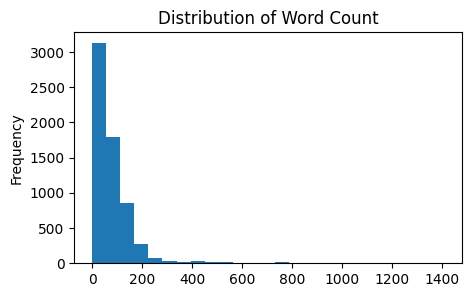

In [57]:
plt.figure(figsize=(5,3))
df_host_about['word_count'].hist(bins=25)
plt.grid(False)  
plt.title('Distribution of Word Count')
plt.ylabel('Frequency')
plt.show()

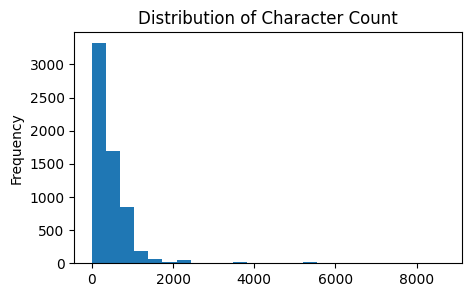

In [58]:
plt.figure(figsize=(5,3))
df_host_about['char_count'].hist(bins=25)
plt.grid(False)  
plt.title('Distribution of Character Count')
plt.ylabel('Frequency')
plt.show()

In [59]:
all_words_host_about_column = ' '.join(df_host_about['host_about']).split()
freq_host_about_column = pd.Series(all_words_host_about_column).value_counts().sort_values(ascending=False)
freq_host_about_column.head(10)

and    16358
to     13291
the    10797
a      10535
in      9860
of      6524
I       6419
you     6248
de      4325
We      4206
Name: count, dtype: int64

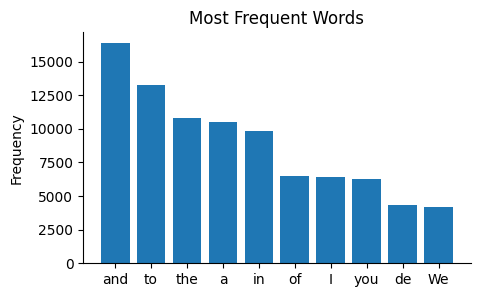

In [60]:
plt.figure(figsize=(5,3))
plt.grid(False)
plt.bar(freq_host_about_column.index[0:10], freq_host_about_column[:10])
plt.xticks(freq_host_about_column.index[0:10])
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

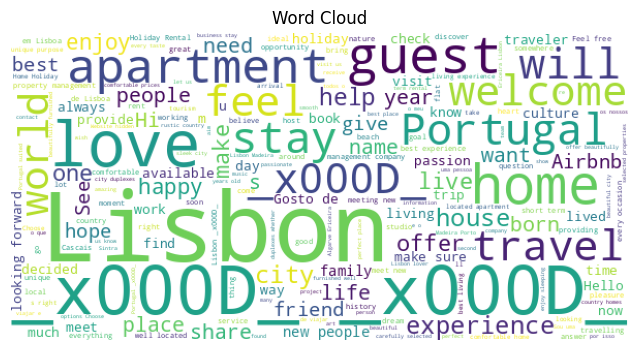

In [61]:
# Joining all the hosts_about into a single string
all_host_about = ' '.join(df_host_about['host_about'])
    
# Create WordCloud object
wordcloud = WordCloud(width=600, height=300, background_color="white").generate(all_host_about)

#Plotting the word cloud
plt.figure(figsize=(8,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

### 4.9 Comparing language from description and host_about columns

In [62]:
# Extracting language columns into lists
d = df_description['language_d'].tolist()
h = df_host_about['language_ha'].tolist()

# Initialize a list to store pairs where values differ
pairs = []

# Loop through the lists and collect differing pairs
for index in range(len(d)):
    if d[index] != h[index]:
        pairs.append((d[index], h[index]))

# Use Counter to count the occurrences of each pair
pair_counts = Counter(pairs)

# Convert the counter to a DataFrame for better visualization
pair_counts_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Count'])

# Print the result
print(pair_counts_df)

             Pair  Count
0        (en, pt)    697
1        (pt, en)    289
2      (en, None)     48
3        (en, es)     47
4     (en, zh-cn)     22
5        (en, it)     30
6   (pt, unknown)     12
7        (pt, it)     12
8        (fr, en)     20
9   (en, unknown)     15
10       (en, fr)     63
11       (da, pt)     24
12       (pt, es)     18
13       (en, de)     11
14       (en, ca)     36
15       (en, nl)      4
16     (pt, None)     17
17       (da, en)     24
18       (es, pt)      7
19    (pt, zh-tw)      3
20       (en, sv)      2
21       (en, da)      1
22       (pt, fr)     12
23  (fr, unknown)      1
24    (da, zh-cn)      3
25     (de, None)      2
26       (pt, la)      1
27       (fr, pt)      3
28       (en, af)      1
29       (pt, de)      1
30  (da, unknown)      4
31       (es, en)      2
32       (sv, en)      1
33    (zh-cn, fr)      1
34       (pt, ca)      4
35       (en, tr)      1
36       (da, it)      1
37       (da, af)      1
38       (en, et)      2


### 4.10. Comments Column Analyse

#### 4.10.1. Language Analyse

In [63]:
airbnb_train_reviews['language_c'] = airbnb_train_reviews['comments'].apply(detect_language)
airbnb_train_reviews['language_c'].value_counts()

language_c
en       232328
fr        53275
pt        22455
es        19234
de        14205
it         5669
nl         3576
ru         1503
ko         1467
zh-cn      1039
ro          818
pl          597
ca          571
da          464
sv          374
af          341
no          311
so          277
cs          207
fi          204
id          164
tl          153
hu          138
ja          109
cy          109
he           91
zh-tw        90
hr           83
sk           71
sw           71
tr           65
lt           55
vi           51
el           49
uk           45
sl           34
et           21
bg           14
lv           13
ar            9
sq            8
mk            2
ur            1
Name: count, dtype: int64

#### 4.10.2. Sentiment Score Implementation

In [64]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def sentiment_score(review, max_length=512):
    # Tokenize the review
    tokens = tokenizer.encode(review, max_length=max_length, truncation=True, return_tensors='pt')
    # Check if the length exceeds the maximum
    if tokens.shape[1] > max_length:
        # Truncate if necessary
        tokens = tokens[:, :max_length]
    # Get the sentiment score
    result = model(tokens)
    return int(torch.argmax(result.logits)) + 1


### 4.11 Final Insights

#### Number of reviews per airbnb

In [65]:
# Count the occurrences of each index in the 'index' column of airbnb_train_reviews
index_counts = airbnb_train_reviews['index'].value_counts()

# Map the index counts to a new column in airbnb_df_train and fill NaN values with 0
airbnb_df_train['reviews'] = airbnb_df_train.index.map(index_counts.get).fillna(0).astype(int)

In [66]:
airbnb_df_train.head()

,description,host_about,unlisted,reviews
index,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,50
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,0
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,0
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,41


In [67]:
airbnb_df_train[airbnb_df_train['reviews'] == 0]['unlisted'].value_counts()

unlisted
1    1441
0     562
Name: count, dtype: int64

In [68]:
airbnb_df_train[airbnb_df_train['reviews'] > 0]['unlisted'].value_counts()

unlisted
0    3978
1     267
Name: count, dtype: int64

##### Important Note: Properties with reviews have a more probability to be listed

<a class="anchor" id="topic05" /><br>
## 5. Data Preprocessing
[Back to Index](#index)


In [69]:
aux1 = airbnb_df_train.merge(df_description['language_d'], left_on='index', right_on='index', how='left')
airbnb_df_train = aux1.merge(df_host_about['language_ha'], left_on='index', right_on='index', how='left')
airbnb_df_train.head()

,description,host_about,unlisted,reviews,language_d,language_ha
index,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,50,en,pt
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,0,pt,en
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,0,en,en
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,0,pt,en
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,41,fr,fr


### 5.1. Lowercase

In [70]:
# description column
airbnb_df_train['description'] = airbnb_df_train['description'].apply(lambda x: " ".join(word.lower() for word in x.split()))

# host_about column
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(lambda x: " ".join(word.lower() for word in x.split()))

In [71]:
airbnb_df_train.head()

,description,host_about,unlisted,reviews,language_d,language_ha
index,,,,,,
1,"this is a shared mixed room in our hostel, wit...",alojamento local registro: 20835/al,0,50,en,pt
2,"o meu espaço fica perto de parque eduardo vii,...","i am friendly host, and i will try to always b...",1,0,pt,en
3,trafaria’s house is a cozy and familiar villa ...,"i am a social person liking to communicate, re...",1,0,en,en
4,"apartamento charmoso no chiado, entre o largo ...",hello!_x000d_ i m portuguese and i love to mee...,0,0,pt,en
5,joli appartement en bordure de mer.<br /> 2 mi...,nous sommes une famille avec deux enfants de 1...,0,41,fr,fr


### 5.2. HTML Tags
We will start by removing the expressions like "< br />"

In [72]:
def remove_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator=' ')
    return clean_text

airbnb_df_train['description'] = airbnb_df_train['description'].apply(remove_tags)
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(remove_tags)

In [73]:
airbnb_df_train.head()

,description,host_about,unlisted,reviews,language_d,language_ha
index,,,,,,
1,"this is a shared mixed room in our hostel, wit...",alojamento local registro: 20835/al,0,50,en,pt
2,"o meu espaço fica perto de parque eduardo vii,...","i am friendly host, and i will try to always b...",1,0,pt,en
3,trafaria’s house is a cozy and familiar villa ...,"i am a social person liking to communicate, re...",1,0,en,en
4,"apartamento charmoso no chiado, entre o largo ...",hello!_x000d_ i m portuguese and i love to mee...,0,0,pt,en
5,joli appartement en bordure de mer. 2 min. a ...,nous sommes une famille avec deux enfants de 1...,0,41,fr,fr


### 5.3. Regular Expressions

In [74]:
# Define the replacement dictionary
replacement_dict = {
    r'License number': 'license',
    r'Alojamento Local Registro': 'alojamento',
    r'_x000d_': ''
}

def update_regex(text, replacement_dict):
    # Apply regular expressions to replace specific patterns
    for pattern, replacement in replacement_dict.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    return text

# Apply the updated function to the specified columns in each DataFrame
airbnb_df_train['description'] = airbnb_df_train['description'].apply(lambda x: update_regex(x, replacement_dict))
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(lambda x: update_regex(x, replacement_dict))

In [75]:
airbnb_df_train.head()

,description,host_about,unlisted,reviews,language_d,language_ha
index,,,,,,
1,"this is a shared mixed room in our hostel, wit...",alojamento: 20835/al,0,50,en,pt
2,"o meu espaço fica perto de parque eduardo vii,...","i am friendly host, and i will try to always b...",1,0,pt,en
3,trafaria’s house is a cozy and familiar villa ...,"i am a social person liking to communicate, re...",1,0,en,en
4,"apartamento charmoso no chiado, entre o largo ...",hello! i m portuguese and i love to meet peopl...,0,0,pt,en
5,joli appartement en bordure de mer. 2 min. a ...,nous sommes une famille avec deux enfants de 1...,0,41,fr,fr


### 5.4. Symbols

In [76]:
def remove_symbols(text):
    symbols_to_remove = ["▲", "☼", "★", "»", "💯"]  
    for symbol in symbols_to_remove:
        text = text.replace(symbol, "")
    return text

# Apply the function to the 'description' and 'host_about' columns
airbnb_df_train['description'] = airbnb_df_train['description'].apply(remove_symbols)
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(remove_symbols)

### 5.5. Contractions

In [77]:
airbnb_df_train['description'][150]

"welcome to our apartment! we believe this beautiful apartment will be a plus in your lisbon experience. with 1 bedroom, a well-equipped kitchen and a pleasant living room with a sofa bed, you will be the heart of alfama area, city center, served by great transport links and a great place to stay in and enjoy lisbon. we hope you enjoy your stay! the space a stylish one-bedroom apartment that serves as a perfect base for visiting lisbon. the living area is light and airy with a beautiful, modern design and lovely finishing touches. it’s a welcoming and inviting space where you can kick back. the master bedroom has a super comfortable queen bed, and with fresh sheets, what more do you need for a good night’s sleep? you'll have a sofa bed in the living room, where can sleep. our property will be professionally cleaned before your stay. guest access guests have access to all the facilities of the space, where they can r"

In [78]:
def expand_contractions(text):
    # Expand contractions
    expanded_text = contractions.fix(text)
    return expanded_text

airbnb_df_train['description'] = airbnb_df_train['description'].apply(expand_contractions)
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(expand_contractions)

In [79]:
# converted "you'll" to "you will"

airbnb_df_train['description'][150]

'welcome to our apartment! we believe this beautiful apartment will be a plus in your lisbon experience. with 1 bedroom, a well-equipped kitchen and a pleasant living room with a sofa bed, you will be the heart of alfama area, city center, served by great transport links and a great place to stay in and enjoy lisbon. we hope you enjoy your stay! the space a stylish one-bedroom apartment that serves as a perfect base for visiting lisbon. the living area is light and airy with a beautiful, modern design and lovely finishing touches. it is a welcoming and inviting space where you can kick back. the master bedroom has a super comfortable queen bed, and with fresh sheets, what more do you need for a good night’s sleep? you will have a sofa bed in the living room, where can sleep. our property will be professionally cleaned before your stay. guest access guests have access to all the facilities of the space, where they can r'

###  5.6. Punctuation

In [80]:
def remove_punctuation(input_string):
    # Define the set of punctuation characters
    exclude = set(string.punctuation)
    # Use a list comprehension to filter out punctuation characters
    filtered_string = ''.join(char for char in input_string if char not in exclude)
    
    return filtered_string

airbnb_df_train['description'] = airbnb_df_train['description'].apply(remove_punctuation)
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(remove_punctuation)

In [81]:
airbnb_df_train.head()

,description,host_about,unlisted,reviews,language_d,language_ha
index,,,,,,
1,this is a shared mixed room in our hostel with...,alojamento 20835al,0,50,en,pt
2,o meu espaço fica perto de parque eduardo vii ...,i am friendly host and i will try to always be...,1,0,pt,en
3,trafaria’s house is a cozy and familiar villa ...,i am a social person liking to communicate rea...,1,0,en,en
4,apartamento charmoso no chiado entre o largo d...,hello i m portuguese and i love to meet people...,0,0,pt,en
5,joli appartement en bordure de mer 2 min a pi...,nous sommes une famille avec deux enfants de 1...,0,41,fr,fr


###  5.7. Handle Numbers

In [82]:
def replace_numbers(text):
    # Replace numbers with '#NUMBER'
    text = re.sub(r'\b\d+\b', 'number', text)
    # Replace 'ALOJAMENTOLOCAL' followed by digits and optionally followed by 'al' with '#ALOJAMENTOLOCAL'
    text = re.sub(r'ALOJAMENTOLOCAL\s*\d+al', 'alojamento', text)
    # Replace numbers followed by a word or unit with 'NUMBER<unit>'
    text = re.sub(r'\b(\d+)([a-zA-Z]+(?:\^2)?)\b', r'number\2', text)
    
    return text


airbnb_df_train['description'] = airbnb_df_train['description'].apply(replace_numbers)
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(replace_numbers)

In [83]:
airbnb_df_train.head()

,description,host_about,unlisted,reviews,language_d,language_ha
index,,,,,,
1,this is a shared mixed room in our hostel with...,alojamento numberal,0,50,en,pt
2,o meu espaço fica perto de parque eduardo vii ...,i am friendly host and i will try to always be...,1,0,pt,en
3,trafaria’s house is a cozy and familiar villa ...,i am a social person liking to communicate rea...,1,0,en,en
4,apartamento charmoso no chiado entre o largo d...,hello i m portuguese and i love to meet people...,0,0,pt,en
5,joli appartement en bordure de mer number min...,nous sommes une famille avec deux enfants de n...,0,41,fr,fr


###  5.8. WordNinja

In [84]:
import wordninja
import pandas as pd

# Define a function to correct text using wordninja
def correct_text(text):
    return ' '.join(wordninja.split(text))

# Apply the correction to the dataframe
airbnb_df_train['description'] = airbnb_df_train.apply(
    lambda row: correct_text(row['description']) if row['language_d'] == 'en' else row['description'], axis=1
)

airbnb_df_train['host_about'] = airbnb_df_train.apply(
    lambda row: correct_text(row['host_about']) if row['language_ha'] == 'en' else row['host_about'], axis=1
)


###  5.9. Stop words

In [85]:
def remove_stopwords(text, stopwords):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords]
    return ' '.join(filtered_tokens)

# Remove stop words from description based on language
for lang in airbnb_df_train['language_d'].dropna().unique():
    stopwords = stopwords_by_language_description.get(lang, [])
    airbnb_df_train.loc[airbnb_df_train['language_d'] == lang, 'description'] = airbnb_df_train[airbnb_df_train['language_d'] == lang]['description'].apply(lambda x: remove_stopwords(x, stopwords))

# Remove stop words from host_about based on language
for lang in airbnb_df_train['language_ha'].dropna().unique():
    stopwords = stopwords_by_language_host_about.get(lang, [])
    airbnb_df_train.loc[airbnb_df_train['language_ha'] == lang, 'host_about'] = airbnb_df_train[airbnb_df_train['language_ha'] == lang]['host_about'].apply(lambda x: remove_stopwords(x, stopwords))

In [86]:
airbnb_df_train.head()

,description,host_about,unlisted,reviews,language_d,language_ha
index,,,,,,
1,shared mixed room hostel shared bathroom locat...,alojamento numberal,0,50,en,pt
2,espaço fica perto parque eduardo vii saldanha ...,friendly host try always around need anything ...,1,0,pt,en
3,tra faria house cozy familiar villa facilities...,social person liking communicate reading trave...,1,0,en,en
4,apartamento charmoso chiado largo carmo traves...,hello portuguese love meet people around word ...,0,0,pt,en
5,joli appartement bordure mer number min a pied...,famille deux enfants number number ans habité ...,0,41,fr,fr


### 5.10 Lemmatize

#### 5.10.1 Lemmatize correction

In [87]:
teste = airbnb_df_train
teste2 = airbnb_df_train
airbnb_df_train_spacy = airbnb_df_train

#### Words in each column with 1and 2 letters and the count of them, in order to understand which ones are being transformed from and in

In [88]:
def extract_and_count_short_words(text):
    # Use regex to find words with 3 or fewer letters
    words = re.findall(r'\b\w{1,2}\b', text)
    return words

def create_short_words_count_dict(df, column1, column2):
    short_words_dict = {'description': Counter(), 'host_about': Counter()}
    
    # Process column1
    for text in df[column1]:
        words = extract_and_count_short_words(text)
        short_words_dict['description'].update(words)
    
    # Process column2
    for text in df[column2]:
        words = extract_and_count_short_words(text)
        short_words_dict['host_about'].update(words)
    
    return short_words_dict

# Create the dictionary with short words and their counts
short_words_count_dict = create_short_words_count_dict(teste, 'description', 'host_about')

print(short_words_count_dict)

{'description': Counter({'tv': 1799, 'al': 1622, 'fi': 1506, 'wi': 1496, 'de': 1443, 'b': 1099, 'da': 1017, 'ro': 934, 'km': 705, 'th': 603, 'e': 572, 'c': 565, '2': 559, 'te': 398, 'x': 396, 'us': 357, 'en': 349, 'to': 339, 'h': 325, 'st': 316, 'n': 313, 'pm': 305, 'go': 277, 'pé': 263, 'wc': 258, '19': 257, 'jo': 251, 'es': 250, 'l': 223, 'ac': 207, 'cm': 204, 'rd': 198, 'ar': 193, 'dr': 185, 'os': 176, 'u': 169, 'ed': 169, 'nd': 168, 'br': 166, 'p': 156, 'qm': 150, 'pr': 150, 'co': 139, 'in': 131, 'id': 123, 'w': 113, 'pe': 110, 'av': 99, 'of': 97, 'r': 94, 'ap': 91, 'ca': 90, 'el': 90, 'il': 90, 'na': 87, 'nb': 87, 'la': 83, 'f': 80, 'is': 80, 'i': 80, 'po': 79, 'ra': 76, 'mo': 75, 'ho': 72, 'ha': 72, 'g': 70, 'a': 67, 'pa': 67, 'ce': 64, 'ou': 64, 'tr': 64, 'v': 62, 'ii': 55, 'mn': 54, 'zi': 51, 'um': 49, 'oe': 49, '28': 49, '1': 48, 'j': 47, 'm': 47, 'ft': 45, '00': 43, 'vi': 43, 'si': 42, 'sq': 42, 'lu': 41, 'le': 41, 'hi': 40, 'li': 40, 'se': 40, 'ex': 40, 'et': 40, 'á': 40, 'l

In [89]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each token and join them back
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    return lemmatized_text

teste2['description'] = teste2['description'].apply(lemmatize_text)
teste2['host_about'] = teste2['host_about'].apply(lemmatize_text)

In [90]:
short_words_count_dict2 = create_short_words_count_dict(teste2, 'description', 'host_about')

print(short_words_count_dict2)

{'description': Counter({'tv': 1810, 'al': 1623, 'fi': 1506, 'wi': 1496, 'de': 1495, 'da': 1232, 'b': 1099, 'ro': 985, 'e': 822, 'km': 746, 'th': 603, 'c': 565, '2': 559, 'u': 526, 'te': 406, 'x': 396, 'en': 353, 'to': 339, 'h': 325, 'st': 316, 'n': 316, 'go': 315, 'pm': 305, 'pé': 263, 'wc': 258, '19': 257, 'jo': 251, 'do': 235, 'l': 223, 'ac': 207, 'cm': 204, 'le': 203, 'rd': 198, 'ar': 193, 'dr': 185, 'o': 179, 'ed': 169, 'nd': 168, 'br': 166, 'p': 165, 'qm': 150, 'pr': 150, 'co': 149, 'in': 132, 'id': 130, 'mo': 126, 'r': 119, 'ca': 118, 'pe': 117, 'w': 114, 'li': 112, 'ha': 99, 'av': 99, 'of': 97, 'na': 96, 'nb': 93, 'po': 92, 'ap': 91, 'el': 90, 'la': 90, 'il': 90, 'f': 81, 'is': 80, 'i': 80, 'ho': 79, 'ra': 79, 'pa': 74, 'g': 72, 'a': 69, 'ce': 66, 'ou': 64, 'tr': 64, 'v': 64, 'mt': 56, 'ii': 55, 'vi': 55, 'm': 55, 'mn': 54, 'zi': 51, 'un': 50, 'um': 49, 'oe': 49, '28': 49, '1': 48, 'j': 47, 'ft': 45, '00': 43, 'lu': 43, 'si': 42, 'sq': 42, 'hi': 40, 'se': 40, 'ex': 40, 'et': 40

#### 5.10.2 Lemmatize Application

In [91]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Custom dictionary for special cases
custom_lemma = {
    "u": "you",
    "sqm": "METRIC",
    "m²": "METRIC",
    "ha": "METRIC",
    "cm": "METRIC",
    "km": "MTERIC",
    "m2": "METRIC",
    "sq": "METRIC",
    "mt": "METRIC",
    "nº": "number"
    
}

# Function to preprocess text and replace specific terms
def preprocess_text(text):
    # Replace "u" with "you"
    text = re.sub(r'\bu\b', 'you', text)
    return text

# Function to lemmatize text with custom handling
def custom_lemmatize(word):
    return custom_lemma.get(word, lemmatizer.lemmatize(word))

#### 5.10.3 Spacy Lemmatize 

In [92]:
nlp = spacy.load("en_core_web_sm")
# Function to lemmatize text using SpaCy with custom handling
def spacy_lemmatize(text):
    # Preprocess the text
    text = preprocess_text(text)
    # Process the text with SpaCy
    doc = nlp(text)
    # Lemmatize each token with custom handling
    lemmatized_text = ' '.join([custom_lemmatize(token.text) if token.text in custom_lemma else token.lemma_ for token in doc])
    return lemmatized_text

# Apply the spacy_lemmatize function to each column
airbnb_df_train_spacy['description'] = airbnb_df_train_spacy['description'].apply(spacy_lemmatize)
airbnb_df_train_spacy['host_about'] = airbnb_df_train_spacy['host_about'].apply(spacy_lemmatize)

In [93]:
airbnb_df_train_spacy.tail()

,description,host_about,unlisted,reviews,language_d,language_ha
index,,,,,,
6244,studio number new well decorate cozy apartment...,brand manager lisbon portugal grow macau south...,0,100,en,en
6245,lisbon meet cosmopolitan industrial one bedroo...,home feeling visitor let comfort reflect big p...,0,130,en,en
6246,license exempt,travel agent passionate culture welcome guest ...,1,25,en,en
6247,campo pe que prestige classy top quality apart...,família portugal gavião música passeio,0,25,en,pt
6248,apartment well locate good neighborhood number...,base vida família paixão corrida,0,275,en,pt


In [94]:
airbnb_df_train = airbnb_df_train_spacy.copy()

#### 5.11 Sentiment Analysis

***Note: the cell below  is commented because we ran these steps and saved the final dataset to a dataframe in order to save time and avoid having to run everything all the time.***

In [95]:
#airbnb_train_reviews['sentiment'] = airbnb_train_reviews['comments'].apply(lambda x: sentiment_score(x))
#airbnb_train_reviews.to_csv('airbnb_train_reviews_with_sentiment_score.csv', index=False)

In [96]:
airbnb_train_reviews = pd.read_csv('./Project Corpora/airbnb_train_reviews_with_sentiment_score.csv')
airbnb_train_reviews

,index,comments,sentiment
0,1,this is a very cozy and comfortable house to s...,5
1,1,good<br/>,4
2,1,"My first hostel experience, and all I have to ...",5
3,1,Das Hostel war neu und deshalb funktionierte a...,4
4,1,"It was fine for a dorm, but I think for the pe...",3
...,...,...,...
361274,6248,The location was perfect. The apartment was ve...,5
361275,6248,Ana's place is exactly as described and even b...,5
361276,6248,A Ana foi muito atenciosa e preocupou se com o...,5
361277,6248,No wifi nor answer. <br/>The wifi can’t be con...,3


In [97]:
airbnb_train_reviews['sentiment'].value_counts()

sentiment
5    255399
4     86504
3     12301
2      4459
1      2616
Name: count, dtype: int64

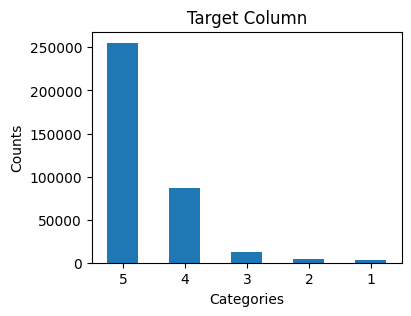

In [98]:
plt.figure(figsize=(4,3))
airbnb_train_reviews['sentiment'].value_counts().plot(kind='bar')
plt.title('Target Column')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

In [99]:
airbnb_train_reviews.groupby('index')['sentiment'].mean().sort_values(ascending=True)

index
3399    1.0
5550    1.0
1808    1.0
4535    1.0
389     1.0
       ... 
4319    5.0
2154    5.0
5588    5.0
4901    5.0
2735    5.0
Name: sentiment, Length: 4245, dtype: float64

### 5.12 Data Exploration after data preprocessing

#### 5.12.1. Description column

In [100]:
df_description_after_preprocessing =  airbnb_df_train[['description', 'unlisted']].copy()
df_description_after_preprocessing

,description,unlisted
index,,
1,share mixed room hostel share bathroom locate ...,0
2,espaço fica perto parque eduardo vii saldanha ...,1
3,tra faria house cozy familiar villa facility n...,1
4,apartamento charmoso chiado largo carmo traves...,0
5,joli appartement bordure mer number min a pie ...,0
...,...,...
6244,studio number new well decorate cozy apartment...,0
6245,lisbon meet cosmopolitan industrial one bedroo...,0
6246,license exempt,1


In [101]:
df_description_after_preprocessing['word_count'] = df_description_after_preprocessing['description'].apply(lambda x: len(x.split()))
df_description_after_preprocessing['char_count'] = df_description_after_preprocessing['description'].apply(lambda x: len(x))
df_description_after_preprocessing['average_word_lenght'] = df_description_after_preprocessing['description'].apply(lambda x: average_words(x))
df_description_after_preprocessing.head(10)

,description,unlisted,word_count,char_count,average_word_lenght
index,,,,,
1,share mixed room hostel share bathroom locate ...,0,74,441,4.972973
2,espaço fica perto parque eduardo vii saldanha ...,1,15,108,6.266667
3,tra faria house cozy familiar villa facility n...,1,113,696,5.168142
4,apartamento charmoso chiado largo carmo traves...,0,27,181,5.740741
5,joli appartement bordure mer number min a pie ...,0,74,505,5.837838
6,important response c ovid 19 property extend c...,0,93,680,6.322581
7,home rent travel perfect vacation without car ...,1,87,476,4.482759
8,find tranquility meticulously curate lifestyle...,0,69,464,5.739130
9,charming apartment one bedroom double bed doub...,0,90,579,5.444444


In [102]:
df_description_after_preprocessing.describe()

,unlisted,word_count,char_count,average_word_lenght
count,6248.000000,6248.000000,6248.000000,6248.000000
mean,0.273367,79.957426,537.030090,5.794590
std,0.445724,28.814984,190.444002,0.618618
min,0.000000,2.000000,10.000000,3.548387
25%,0.000000,61.000000,409.000000,5.428571
50%,0.000000,91.000000,618.000000,5.720430
75%,1.000000,99.000000,668.000000,6.065360
max,1.000000,162.000000,867.000000,15.400000


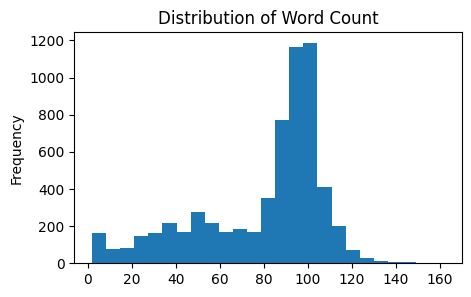

In [103]:
plt.figure(figsize=(5,3))
df_description_after_preprocessing['word_count'].hist(bins=25)
plt.grid(False)  
plt.title('Distribution of Word Count')
plt.ylabel('Frequency')
plt.show()

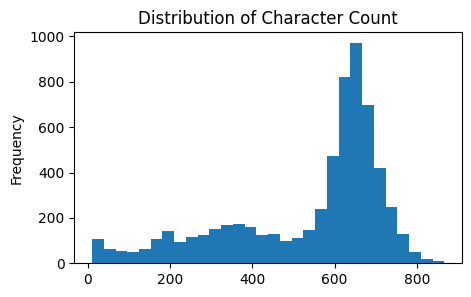

In [104]:
plt.figure(figsize=(5,3))
df_description_after_preprocessing['char_count'].hist(bins=30)
plt.grid(False)  
plt.title('Distribution of Character Count')
plt.ylabel('Frequency')
plt.show()

In [105]:
all_words_description_column = ' '.join(df_description_after_preprocessing['description']).split()
freq_description_column = pd.Series(all_words_description_column).value_counts().sort_values(ascending=False)
freq_description_column.head(10)

number       21688
apartment     9376
lisbon        6323
space         6147
room          5850
bedroom       4767
guest         4175
bed           4105
locate        3885
kitchen       3708
Name: count, dtype: int64

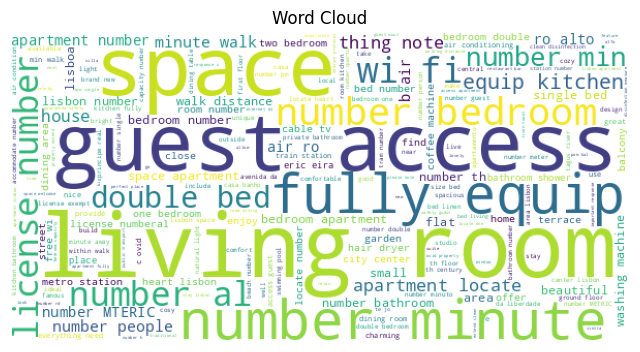

In [106]:
# Joining all the descriptions into a single string
all_descriptions = ' '.join(df_description_after_preprocessing['description'])
    
# Create WordCloud object
wordcloud = WordCloud(width=600, height=300, background_color="white").generate(all_descriptions)

#Plotting the word cloud
plt.figure(figsize=(8,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

#### 5.12.2. Host_about column column

In [107]:
df_host_about_after_preprocessing =  airbnb_df_train[['host_about', 'unlisted']].copy()
df_host_about_after_preprocessing.head()

,host_about,unlisted
index,,
1,alojamento numberal,0
2,friendly host try always around need anything ...,1
3,social person like communicate reading travel ...,1
4,hello portuguese love meet people around word ...,0
5,famille deux enfant number number an habité pe...,0


In [108]:
df_host_about_after_preprocessing['word_count'] = df_host_about_after_preprocessing['host_about'].apply(lambda x: len(x.split()))
df_host_about_after_preprocessing['char_count'] = df_host_about_after_preprocessing['host_about'].apply(lambda x: len(x))
df_host_about_after_preprocessing['average_word_lenght'] = df_host_about_after_preprocessing['host_about'].apply(lambda x: average_words(x))
df_host_about_after_preprocessing.head()

,host_about,unlisted,word_count,char_count,average_word_lenght
index,,,,,
1,alojamento numberal,0,2,19,9.000000
2,friendly host try always around need anything ...,1,12,75,5.333333
3,social person like communicate reading travel ...,1,24,154,5.458333
4,hello portuguese love meet people around word ...,0,16,101,5.375000
5,famille deux enfant number number an habité pe...,0,20,155,6.800000


In [109]:
df_host_about_after_preprocessing.describe()

,unlisted,word_count,char_count,average_word_lenght
count,6248.000000,6248.000000,6248.000000,6248.000000
mean,0.273367,43.184859,289.035051,5.911518
std,0.445724,56.613402,365.535708,2.161444
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,14.000000,96.000000,5.352941
50%,0.000000,30.000000,200.000000,5.764428
75%,1.000000,59.000000,390.250000,6.247312
max,1.000000,1233.000000,7768.000000,67.000000


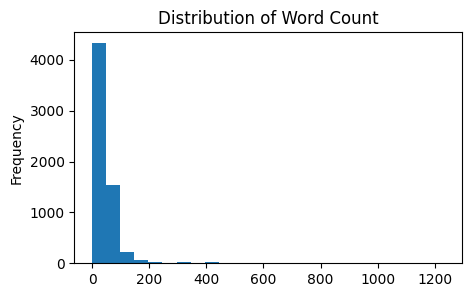

In [110]:
plt.figure(figsize=(5,3))
df_host_about_after_preprocessing['word_count'].hist(bins=25)
plt.grid(False)  
plt.title('Distribution of Word Count')
plt.ylabel('Frequency')
plt.show()

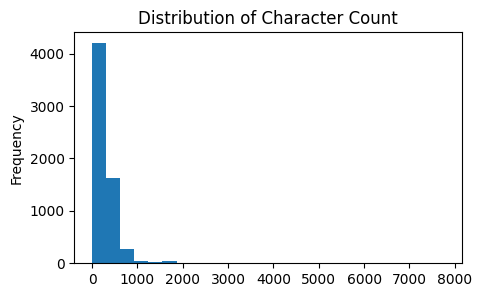

In [111]:
plt.figure(figsize=(5,3))
df_host_about_after_preprocessing['char_count'].hist(bins=25)
plt.grid(False)  
plt.title('Distribution of Character Count')
plt.ylabel('Frequency')
plt.show()

In [112]:
all_words_host_about_column = ' '.join(df_host_about_after_preprocessing['host_about']).split()
freq_host_about_column = pd.Series(all_words_host_about_column).value_counts().sort_values(ascending=False)
freq_host_about_column.head(10)

lisbon        4185
number        3565
love          2847
home          2425
guest         2352
stay          2093
portugal      2080
apartment     2062
travel        2012
experience    1984
Name: count, dtype: int64

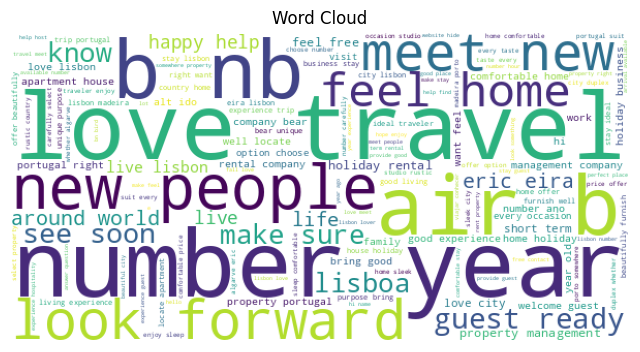

In [113]:
# Joining all the hosts_about into a single string
all_host_about = ' '.join(df_host_about_after_preprocessing['host_about'])
    
# Create WordCloud object
wordcloud = WordCloud(width=600, height=300, background_color="white").generate(all_host_about)

#Plotting the word cloud
plt.figure(figsize=(8,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

#### 5.12.3 NER (named entity recognition) model

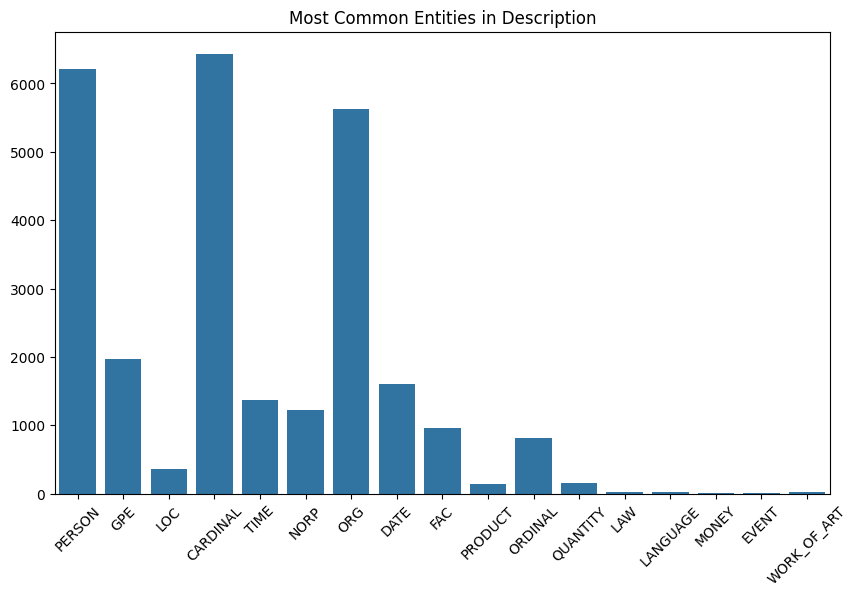

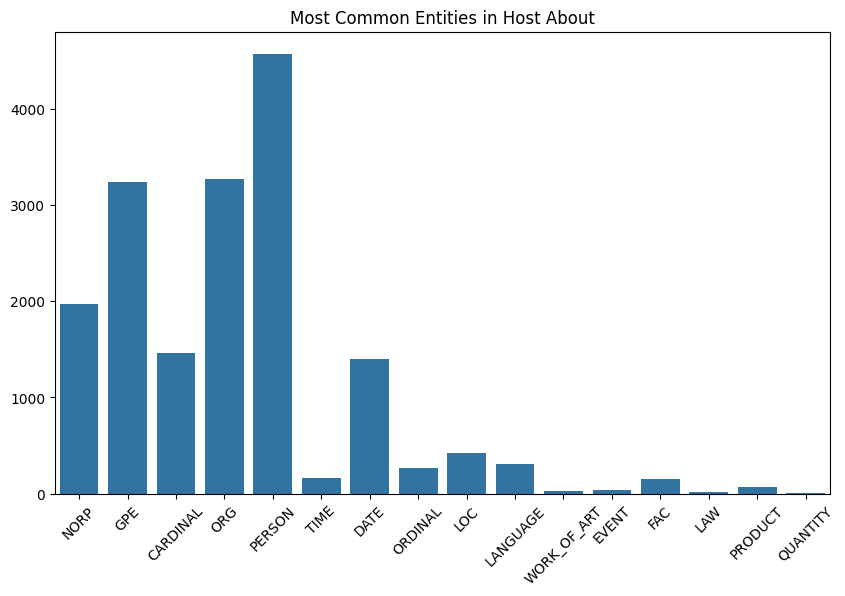

In [114]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Load SpaCy's pre-trained model
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = [ent.label_ for ent in doc.ents]
    return entities

def process_text_in_chunks(text, chunk_size=100000):
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
    all_entities = []
    for chunk in chunks:
        all_entities.extend(extract_entities(chunk))
    return all_entities

# Apply NER to the 'description' column
all_descriptions = ' '.join(airbnb_df_train['description'].dropna().tolist())
description_entities = process_text_in_chunks(all_descriptions)

# Apply NER to the 'host_about' column
all_host_about = ' '.join(airbnb_df_train['host_about'].dropna().tolist())
host_about_entities = process_text_in_chunks(all_host_about)

# Count the most common entities
description_entity_counts = Counter(description_entities)
host_about_entity_counts = Counter(host_about_entities)

# Plot the most common entities in 'description'
plt.figure(figsize=(10, 6))
sns.barplot(x=list(description_entity_counts.keys()), y=list(description_entity_counts.values()))
plt.title('Most Common Entities in Description')
plt.xticks(rotation=45)
plt.show()

# Plot the most common entities in 'host_about'
plt.figure(figsize=(10, 6))
sns.barplot(x=list(host_about_entity_counts.keys()), y=list(host_about_entity_counts.values()))
plt.title('Most Common Entities in Host About')
plt.xticks(rotation=45)
plt.show()

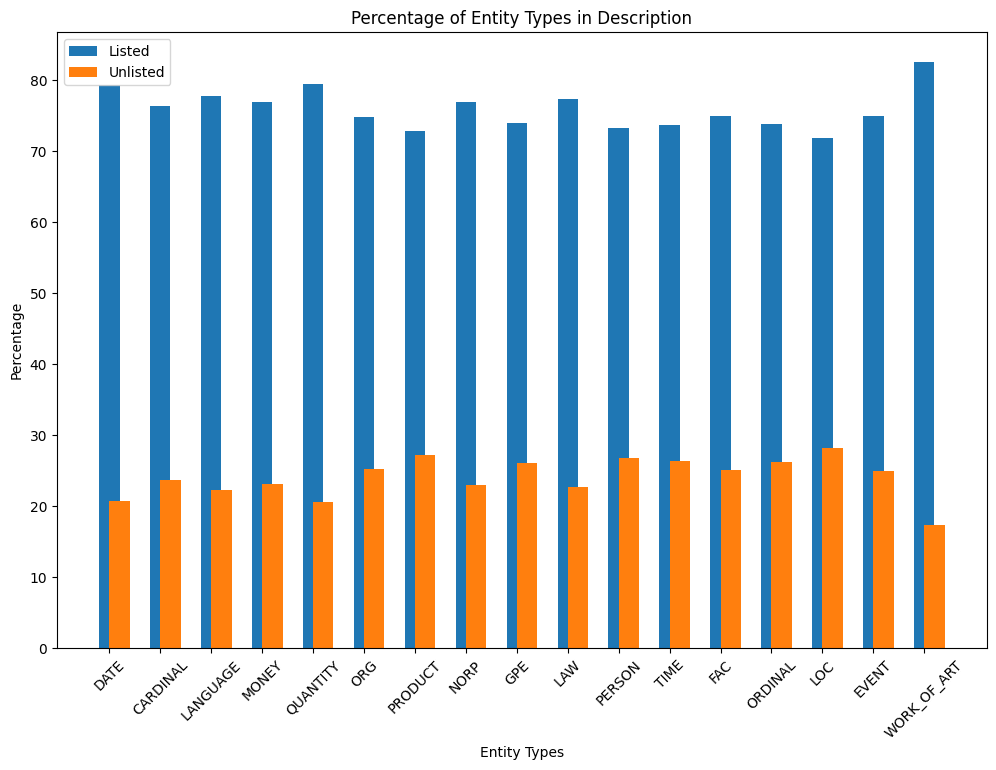

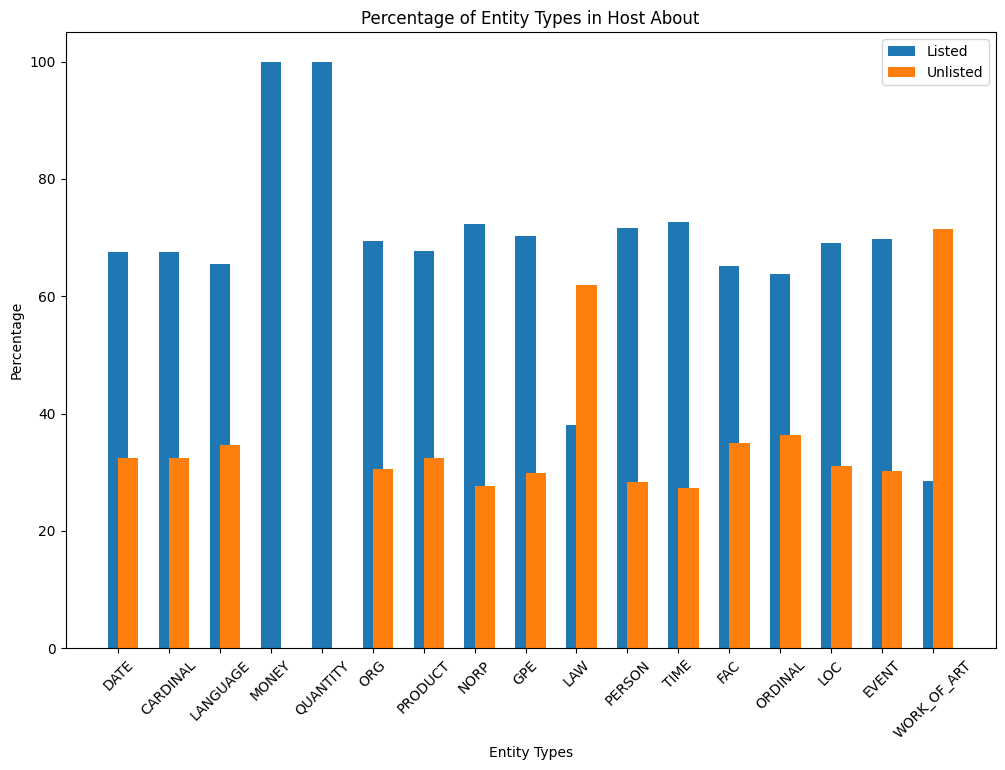

In [115]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load SpaCy's pre-trained model
nlp = spacy.load("en_core_web_sm")

# Function to extract entities from a given text using a pre-trained NLP model
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.label_ for ent in doc.ents]
    return entities

# Function to process text in chunks to handle large text data
def process_text_in_chunks(text, chunk_size=100000):
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
    all_entities = []
    for chunk in chunks:
        all_entities.extend(extract_entities(chunk))
    return all_entities

# Function to get entity counts by 'unlisted' status from a dataframe
def get_entity_counts_by_status(data, column_name):
    listed_entities = []
    unlisted_entities = []

    for index, row in data.iterrows():
        text = row[column_name]
        status = row['unlisted']
        if pd.notna(text):  # Ensure text is not NaN
            entities = process_text_in_chunks(text)
            if status == 0:  # Check if status is 'listed'
                listed_entities.extend(entities)
            else:  # Otherwise, status is 'unlisted'
                unlisted_entities.extend(entities)
    
    return Counter(listed_entities), Counter(unlisted_entities)

# Function to calculate the percentage distribution of entities between listed and unlisted
def calculate_percentage(listed_counts, unlisted_counts):
    all_entities = set(listed_counts.keys()).union(set(unlisted_counts.keys()))
    percentages = {entity: {'listed': 0, 'unlisted': 0} for entity in all_entities}

    for entity in all_entities:
        total_count = listed_counts.get(entity, 0) + unlisted_counts.get(entity, 0)
        if total_count > 0:  # Calculate percentages only if total count is greater than zero
            percentages[entity]['listed'] = (listed_counts.get(entity, 0) / total_count) * 100
            percentages[entity]['unlisted'] = (unlisted_counts.get(entity, 0) / total_count) * 100
    
    return percentages

# Get entity counts for 'description'
description_entity_counts_listed, description_entity_counts_unlisted = get_entity_counts_by_status(airbnb_df_train, 'description')
description_percentages = calculate_percentage(description_entity_counts_listed, description_entity_counts_unlisted)

# Get entity counts for 'host_about'
host_about_entity_counts_listed, host_about_entity_counts_unlisted = get_entity_counts_by_status(airbnb_df_train, 'host_about')
host_about_percentages = calculate_percentage(host_about_entity_counts_listed, host_about_entity_counts_unlisted)

# Function to plot the entity percentages
def plot_entity_percentages(percentages, title):
    entity_types = list(percentages.keys())
    listed_values = [percentages[entity]['listed'] for entity in entity_types]
    unlisted_values = [percentages[entity]['unlisted'] for entity in entity_types]

    x = range(len(entity_types))

    plt.figure(figsize=(12, 8))
    plt.bar(x, listed_values, width=0.4, label='Listed', align='center')
    plt.bar(x, unlisted_values, width=0.4, label='Unlisted', align='edge')
    plt.xticks(x, entity_types, rotation=45)
    plt.xlabel('Entity Types')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot the most common entities in 'description'
plot_entity_percentages(description_percentages, 'Percentage of Entity Types in Description')

# Plot the most common entities in 'host_about'
plot_entity_percentages(host_about_percentages, 'Percentage of Entity Types in Host About')

### 5.13 Split train-val to test oversampling and undersampling

#### 5.13.1 Split train-val

In [116]:
proport_val_size = dicParams["validation_size"] 

X_train, X_val, y_train, y_val = train_test_split(airbnb_df_train.drop(lstvars_targets, axis=1), airbnb_df_train[target_var], 
                                                  test_size=proport_val_size, random_state=g_random_state, 
                                                  stratify=airbnb_df_train[target_var])


#### 5.13.2 Undersampling

In [117]:
under_sampler = RandomUnderSampler(random_state=g_random_state)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

#### 5.13.3 Oversampling

In [118]:
over_sampler = RandomOverSampler(random_state=g_random_state)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

### 5.14 Standard Scaler

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler

StandardScaler()

#### 5.14.1. Undersampling

In [120]:
X_train_num_under = scaler.fit_transform(X_train_under[['reviews']])
X_val_num_under = scaler.transform(X_val[['reviews']])

#### 5.14.2. Oversampling

In [121]:
X_train_num_over = scaler.fit_transform(X_train_over[['reviews']])
X_val_num_over = scaler.transform(X_val[['reviews']])

<a class="anchor" id="topic06" /><br>
## 6. Feature Engineering
[Back to Index](#index)


### 6.1. Define Labels

In [122]:
y_train_under = np.array(y_train_under)
y_train_over = np.array(y_train_over)
y_val = np.array(y_val)

### 6.2. Bag of Words

In [123]:
bow = CountVectorizer(binary=True)
bow

CountVectorizer(binary=True)

#### 6.2.1. Undersampling

In [124]:
X_train_bow_under = bow.fit_transform(X_train_under[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1))
X_val_bow_under = bow.transform(X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1))

In [125]:
print("Bag of words train_under feature matrix shape:", X_train_bow_under.shape)
print("Bag of words validation feature matrix shape:", X_val_bow_under.shape)

Bag of words train_under feature matrix shape: (2732, 15969)
Bag of words validation feature matrix shape: (1250, 15969)


In [126]:
from scipy.sparse import hstack

In [127]:
X_train_bow_under = hstack([X_train_bow_under, X_train_num_under])
X_val_bow_under = hstack([X_val_bow_under, X_val_num_under])

#### 6.2.2. Oversampling

In [128]:
X_train_bow_over = bow.fit_transform(X_train_over[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1))
X_val_bow_over = bow.transform(X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1))

In [129]:
print("Bag of words train_over feature matrix shape:", X_train_bow_over.shape)
print("Bag of words validation feature matrix shape:", X_val_bow_over.shape)

Bag of words train_over feature matrix shape: (7264, 21261)
Bag of words validation feature matrix shape: (1250, 21261)


In [130]:
X_train_bow_over = hstack([X_train_bow_over, X_train_num_over])
X_val_bow_over = hstack([X_val_bow_over, X_val_num_over])

#### 6.3. Bi-grams with Bag of words

In [126]:
# Function to extract the top N-grams from a corpus
def get_top_n_grams(corpus, top_k, n):

    # Create a bag-of-words model that extracts n-grams of size 'n'
    bow = CountVectorizer(binary=True, ngram_range=(n, n)).fit(corpus)
    bag_of_words = bow.transform(corpus)

    # Sum the occurrences of each n-gram across the corpus
    sum_words = bag_of_words.sum(axis=0)

    words_freq = []
    for word, idx in bow.vocabulary_.items():
        # Append the n-gram and its frequency to the list
        words_freq.append((word, sum_words[0, idx]))

    # Sort the n-grams by frequency in descending order
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Create a DataFrame for the top 'top_k' n-grams
    top_df = pd.DataFrame(words_freq[:top_k])
    top_df.columns = ["Ngram", "Freq"]

    return top_df

# Function to plot the frequencies of the top N-grams
def plot_frequencies(top_df):
    
    # Get the labels and values for the top 30 n-grams
    x_labels = top_df["Ngram"][:30]
    y_pos = np.arange(len(x_labels))
    values = top_df["Freq"][:30]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, x_labels)
    plt.ylabel('Frequencies')
    plt.title('Words')
    plt.xticks(rotation=90)
    plt.show()


##### 6.3.1. Description column  

In [127]:
bigrams_description = get_top_n_grams(airbnb_df_train['description'], top_k=20, n=2)
bigrams_description.head(10)

,Ngram,Freq
0,living room,1927
1,guest access,1777
2,fully equip,1477
3,license number,1402
4,number al,1373
5,number bedroom,1269
6,wi fi,1248
7,number minute,1140
8,double bed,1118
9,thing note,1049


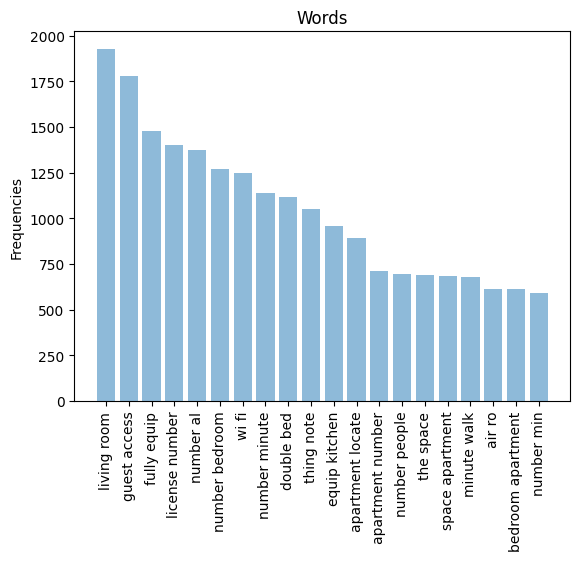

In [128]:
plot_frequencies(bigrams_description)

##### 6.3.2. Host_about column 

In [129]:
bigrams_host_about = get_top_n_grams(airbnb_df_train['host_about'], top_k=20, n=2)
bigrams_host_about.head(10)

,Ngram,Freq
0,love travel,599
1,number year,528
2,new people,372
3,look forward,361
4,meet new,343
5,feel home,342
6,air nb,328
7,see soon,313
8,around world,295
9,make sure,293


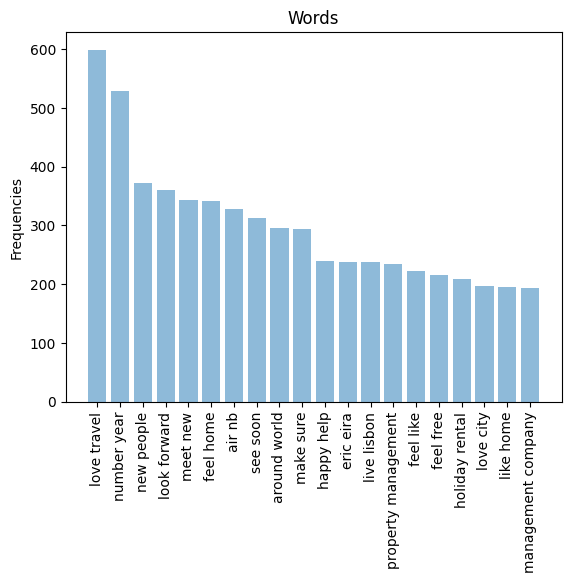

In [130]:
plot_frequencies(bigrams_host_about)

#### 6.4. Tri-grams with Bag of words

##### 6.4.1. Description column  

In [131]:
trigrams_description = get_top_n_grams(airbnb_df_train['description'], top_k=20, n=3)
trigrams_description.head(10)

,Ngram,Freq
0,license number al,1248
1,fully equip kitchen,788
2,air ro alto,575
3,number minute walk,563
4,number bedroom number,361
5,free wi fi,356
6,bedroom double bed,352
7,guest access guest,334
8,number bedroom apartment,325
9,kitchen fully equip,269


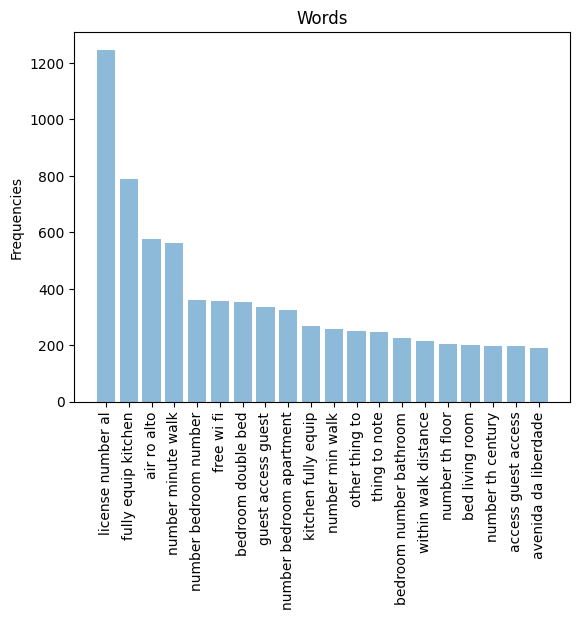

In [132]:
plot_frequencies(trigrams_description)

##### 6.4.2. Host_about column 

In [133]:
trigrams_host_about = get_top_n_grams(airbnb_df_train['host_about'], top_k=20, n=3)
trigrams_host_about.head(10)

,Ngram,Freq
0,meet new people,313
1,feel like home,183
2,property management company,171
3,number year old,161
4,eric eira lisbon,157
5,well locate apartment,156
6,want feel like,155
7,home holiday rental,154
8,like home holiday,153
9,holiday rental company,153


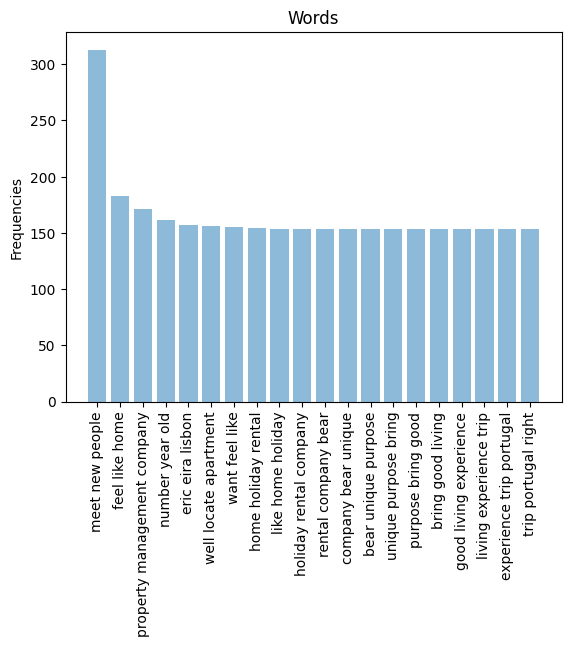

In [134]:
plot_frequencies(trigrams_host_about)

### 6.5. TF-IDF

In [135]:
tfidf = TfidfVectorizer()
tfidf

TfidfVectorizer()

#### 6.5.1. Undersampling

In [136]:
X_train_tfidf_under = tfidf.fit_transform(X_train_under[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1))
X_val_tfidf_under = tfidf.transform(X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1))

In [137]:
print("TF-IDF train_under feature matrix shape:", X_train_tfidf_under.shape)
print("TF-IDF validation feature matrix shape:", X_val_tfidf_under.shape)

TF-IDF train_under feature matrix shape: (2732, 15970)
TF-IDF validation feature matrix shape: (1250, 15970)


In [138]:
X_train_tfidf_under = hstack([X_train_tfidf_under, X_train_num_under])
X_val_tfidf_under = hstack([X_val_tfidf_under, X_val_num_under])

#### 6.5.2. Oversampling

In [139]:
X_train_tfidf_over = tfidf.fit_transform(X_train_over[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1))
X_val_tfidf_over = tfidf.transform(X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1))

In [140]:
print("TF-IDF train_over feature matrix shape:", X_train_tfidf_over.shape)
print("TF-IDF validation feature matrix shape:", X_val_tfidf_over.shape)

TF-IDF train_over feature matrix shape: (7264, 21222)
TF-IDF validation feature matrix shape: (1250, 21222)


In [141]:
X_train_tfidf_over = hstack([X_train_tfidf_over, X_train_num_over])
X_val_tfidf_over = hstack([X_val_tfidf_over, X_val_num_over])

### 6.6. GloVe

In [142]:
# Load pre-trained Word2Vec embeddings
word2vec_model = api.load('word2vec-google-news-300')

In [143]:
# Function to get embeddings for each word in a corpus based on a word2vec model
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        doc_vectors = []
        for word in document.split():
            if word in word2vec_model.index_to_key:  # Check if word is in the word2vec model
                doc_vectors.append(word2vec_model.get_vector(word))  # Get the word vector and append to list
        corpus_vec.append(doc_vectors)
    return corpus_vec


#### 6.6.1. Undersampling

In [144]:
# Combine the 'description' and 'host_about' columns for both datasets
X_train_under_combined = X_train_under[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)
X_val_under_combined = X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)

# Apply the corpus2vec function to the combined training data
X_train_glove_under = corpus2vec(X_train_under_combined)

# Apply the corpus2vec function to the combined validation data
X_val_glove_under = corpus2vec(X_val_under_combined)

100%|██████████| 1250/1250 [20:56<00:00,  1.01s/it] 


In [145]:
# Define a fixed length for the GloVe vectors
fixed_length = 300  

# Function to compute mean of GloVe vectors for each document
def compute_mean_glove_vectors(glove_features):
    glove_features_flat = []
    for doc in glove_features:
        # Filter out empty or invalid documents
        if doc:
            # Check if the document contains valid GloVe vectors
            valid_vectors = [vec for vec in doc if isinstance(vec, np.ndarray) and vec.shape == (300,)]
            if valid_vectors:
                # Pad or truncate GloVe vectors to the fixed length and compute mean
                mean_vec = np.mean(valid_vectors[:fixed_length], axis=0)
                glove_features_flat.append(mean_vec)
            else:
                # Handle case with no valid vectors
                glove_features_flat.append(np.zeros(fixed_length))
        else:
            # Handle case with empty document
            glove_features_flat.append(np.zeros(fixed_length))
    return np.array(glove_features_flat)

# Flatten the GloVe vectors
X_train_glove_under_flat = compute_mean_glove_vectors(X_train_glove_under)
X_val_glove_under_flat = compute_mean_glove_vectors(X_val_glove_under)

# Check shapes after flattening
print("Glove train_under feature matrix shape:", X_train_glove_under_flat.shape)
print("Glove validation feature matrix shape:", X_val_glove_under_flat.shape)


Glove train_under feature matrix shape: (2732, 300)
Glove validation feature matrix shape: (1250, 300)


In [146]:
X_train_glove_under = np.concatenate((X_train_num_under, X_train_glove_under_flat), axis=1)
X_val_glove_under = np.concatenate((X_val_num_under, X_val_glove_under_flat), axis=1)

#### 6.6.2. Oversampling

In [147]:
# Combine the 'description' and 'host_about' columns for both datasets
X_train_over_combined = X_train_over[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)
X_val_over_combined = X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)

# Apply the corpus2vec function to the combined training data
X_train_glove_over = corpus2vec(X_train_over_combined)

# Apply the corpus2vec function to the combined validation data
X_val_glove_over = corpus2vec(X_val_over_combined)

100%|██████████| 1250/1250 [21:44<00:00,  1.04s/it] 


In [148]:
# Define a fixed length for the GloVe vectors
fixed_length = 300  

# Function to compute mean of GloVe vectors for each document
def compute_mean_glove_vectors(glove_features):
    glove_features_flat = []
    for doc in glove_features:
        # Filter out empty or invalid documents
        if doc:
            # Check if the document contains valid GloVe vectors
            valid_vectors = [vec for vec in doc if isinstance(vec, np.ndarray) and vec.shape == (300,)]
            if valid_vectors:
                # Pad or truncate GloVe vectors to the fixed length and compute mean
                mean_vec = np.mean(valid_vectors[:fixed_length], axis=0)
                glove_features_flat.append(mean_vec)
            else:
                # Handle case with no valid vectors
                glove_features_flat.append(np.zeros(fixed_length))
        else:
            # Handle case with empty document
            glove_features_flat.append(np.zeros(fixed_length))
    return np.array(glove_features_flat)

# Flatten the GloVe vectors
X_train_glove_over_flat = compute_mean_glove_vectors(X_train_glove_over)
X_val_glove_over_flat = compute_mean_glove_vectors(X_val_glove_over)

# Check shapes after flattening
print("Glove train_over feature matrix shape:", X_train_glove_over_flat.shape)
print("Glove validation feature matrix shape:", X_val_glove_over_flat.shape)

Glove train_over feature matrix shape: (7264, 300)
Glove validation feature matrix shape: (1250, 300)


In [149]:
X_train_glove_over = np.concatenate((X_train_num_over, X_train_glove_over_flat), axis=1)
X_val_glove_over = np.concatenate((X_val_num_over, X_val_glove_over_flat), axis=1)

### 6.7. LaBSE (Language-agnostic BERT Sentence Embedding)

In [150]:
LaBSE_model = SentenceTransformer('sentence-transformers/LaBSE')

#### 6.7.1. Undersampling

In [151]:
# Combine the 'description' and 'host_about' columns for both datasets
X_train_under_combined = X_train_under[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)
X_val_under_combined = X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)

# Generate embeddings for 'description' and 'host_about' columns
X_train_under_embeddings = LaBSE_model.encode(X_train_under_combined.tolist(), show_progress_bar=True)
X_val_under_embeddings = LaBSE_model.encode(X_val_under_combined.tolist(), show_progress_bar=True)

X_train_LaBSE_under = np.concatenate((X_train_num_under, X_train_under_embeddings), axis=1)
X_val_LaBSE_under = np.concatenate((X_val_num_under, X_val_under_embeddings), axis=1)

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [152]:
print("LaSBE train_under feature matrix shape:", X_train_LaBSE_under.shape)
print("LaSBE validation feature matrix shape:", X_val_LaBSE_under.shape)

LaSBE train_under feature matrix shape: (2732, 769)
LaSBE validation feature matrix shape: (1250, 769)


#### 6.7.2. Oversampling

In [153]:
# Combine the 'description' and 'host_about' columns for both datasets
X_train_over_combined = X_train_over[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)
X_val_over_combined = X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)

# Generate embeddings for 'description' and 'host_about' columns
X_train_over_embeddings = LaBSE_model.encode(X_train_over_combined.tolist(), show_progress_bar=True)
X_val_over_embeddings = LaBSE_model.encode(X_val_over_combined.tolist(), show_progress_bar=True)

X_train_LaBSE_over = np.concatenate((X_train_num_over, X_train_over_embeddings), axis=1)
X_val_LaBSE_over = np.concatenate((X_val_num_over, X_val_over_embeddings), axis=1)

Batches:   0%|          | 0/227 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [154]:
print("LaSBE train_over feature matrix shape:", X_train_LaBSE_over.shape)
print("LaSBE validation feature matrix shape:", X_val_LaBSE_over.shape)

LaSBE train_over feature matrix shape: (7264, 769)
LaSBE validation feature matrix shape: (1250, 769)


### 6.8.  XLM-R (Cross-lingual Language Model with RoBERTa architecture)

In [155]:
XML_R_model = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')

#### 6.8.1. Undersampling

In [156]:
# Combine the 'description' and 'host_about' columns for both datasets
X_train_under_combined = X_train_under[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)
X_val_under_combined = X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)

# Generate embeddings for 'description' and 'host_about' columns
X_train_under_embeddings_XML_R = XML_R_model.encode(X_train_under_combined.tolist(), show_progress_bar=True)
X_val_under_embeddings_XML_R = XML_R_model.encode(X_val_under_combined.tolist(), show_progress_bar=True)

X_train_XML_R_under = np.concatenate((X_train_num_under, X_train_under_embeddings_XML_R), axis=1)
X_val_XML_R_under = np.concatenate((X_val_num_under, X_val_under_embeddings_XML_R), axis=1)

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [157]:
print("XML_R train_under feature matrix shape:", X_train_XML_R_under.shape)
print("XML_R validation feature matrix shape:", X_val_XML_R_under.shape)

XML_R train_under feature matrix shape: (2732, 769)
XML_R validation feature matrix shape: (1250, 769)


#### 6.8.2. Oversampling

In [158]:
# Combine the 'description' and 'host_about' columns for both datasets
X_train_over_combined = X_train_over[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)
X_val_over_combined = X_val[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1)

# Generate embeddings for 'description' and 'host_about' columns
X_train_over_embeddings_XML_R = XML_R_model.encode(X_train_over_combined.tolist(), show_progress_bar=True)
X_val_over_embeddings_XML_R = XML_R_model.encode(X_val_over_combined.tolist(), show_progress_bar=True)

X_train_XML_R_over = np.concatenate((X_train_num_over, X_train_over_embeddings_XML_R), axis=1)
X_val_XML_R_over = np.concatenate((X_val_num_over, X_val_over_embeddings_XML_R), axis=1)

Batches:   0%|          | 0/227 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [159]:
print("XML_R train_over feature matrix shape:", X_train_XML_R_over.shape)
print("XML_R validation feature matrix shape:", X_val_XML_R_over.shape)

XML_R train_over feature matrix shape: (7264, 769)
XML_R validation feature matrix shape: (1250, 769)


<a class="anchor" id="topic07" /><br>
## 7. Classification Models
[Back to Index](#index)

### 7.1. Models with undersampling

#### 7.1.1. Logistic Regression

In [160]:

# Initialize models
models = {
    'BOW': LogisticRegression(random_state=g_random_state),
    'TF-IDF': LogisticRegression(random_state=g_random_state),
    'GloVe': LogisticRegression(random_state=g_random_state),
    'LaSBE': LogisticRegression(random_state=g_random_state),
    'XLM-R': LogisticRegression(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_lr = pd.DataFrame(results)
df_lr = df_lr[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
               'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_lr)


    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.991947     0.992            0.992         0.992   
1  TF-IDF        0.878843     0.878            0.884         0.879   
2   GloVe        0.772328     0.767            0.800         0.772   
3   LaSBE        0.785139     0.782            0.805         0.785   
4   XLM-R        0.828331     0.828            0.831         0.828   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.7056          0.720                 0.764              0.706  
1               0.7416          0.755                 0.821              0.742  
2               0.6976          0.714                 0.813              0.698  
3               0.7104          0.726                 0.814              0.710  
4               0.7032          0.719                 0.773              0.703  


#### 7.1.2. Multi-Layer Perceptron 

In [161]:
models = {
    'BOW': MLPClassifier(random_state=g_random_state),
    'TF-IDF': MLPClassifier(random_state=g_random_state),
    'GloVe': MLPClassifier(random_state=g_random_state),
    'LaSBE': MLPClassifier(random_state=g_random_state),
    'XLM-R': MLPClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_mlp = pd.DataFrame(results)
df_mlp = df_mlp[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
               'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_mlp)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.997804     0.998            0.998         0.998   
1  TF-IDF        0.997438     0.997            0.997         0.997   
2   GloVe        0.900073     0.900            0.901         0.900   
3   LaSBE        0.941435     0.941            0.941         0.941   
4   XLM-R        0.995242     0.995            0.995         0.995   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.6808          0.697                 0.744              0.681  
1               0.7264          0.740                 0.781              0.726  
2               0.8344          0.838                 0.846              0.834  
3               0.8192          0.826                 0.847              0.819  
4               0.7464          0.755                 0.774              0.746  


#### 7.1.3. K-Nearest Neighbours (KNN)

In [162]:
# Initialize models
models = {
    'BOW': KNeighborsClassifier(),
    'TF-IDF': KNeighborsClassifier(),
    'GloVe': KNeighborsClassifier(),
    'LaSBE': KNeighborsClassifier(),
    'XLM-R': KNeighborsClassifier()
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_knn = pd.DataFrame(results)
df_knn = df_knn[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_knn)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.819912     0.819            0.828         0.820   
1  TF-IDF        0.837848     0.838            0.839         0.838   
2   GloVe        0.848097     0.848            0.849         0.848   
3   LaSBE        0.843704     0.843            0.846         0.844   
4   XLM-R        0.790630     0.790            0.791         0.791   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.6120          0.629                 0.773              0.612  
1               0.7672          0.778                 0.810              0.767  
2               0.7912          0.799                 0.822              0.791  
3               0.7784          0.788                 0.817              0.778  
4               0.6640          0.682                 0.740              0.664  


#### 7.1.4. Support Vector Machines (SVM)

In [163]:
models = {
    'BOW': SVC(random_state=g_random_state),
    'TF-IDF': SVC(random_state=g_random_state),
    'GloVe': SVC(random_state=g_random_state),
    'LaSBE': SVC(random_state=g_random_state),
    'XLM-R': SVC(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_svm = pd.DataFrame(results)
df_svm = df_svm[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_svm)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.948389     0.948            0.949         0.948   
1  TF-IDF        0.904100     0.904            0.905         0.904   
2   GloVe        0.815886     0.814            0.826         0.816   
3   LaSBE        0.819180     0.818            0.829         0.819   
4   XLM-R        0.822840     0.821            0.840         0.823   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.7232          0.738                 0.793              0.723  
1               0.8128          0.821                 0.856              0.813  
2               0.7768          0.788                 0.838              0.777  
3               0.7768          0.788                 0.838              0.777  
4               0.6896          0.706                 0.808              0.690  


#### 7.1.5. Random Forests

In [164]:
models = {
    'BOW': RandomForestClassifier(random_state=g_random_state),
    'TF-IDF': RandomForestClassifier(random_state=g_random_state),
    'GloVe': RandomForestClassifier(random_state=g_random_state),
    'LaSBE': RandomForestClassifier(random_state=g_random_state),
    'XLM-R': RandomForestClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_rf = pd.DataFrame(results)
df_rf = df_rf[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_rf)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.998902     0.999            0.999         0.999   
1  TF-IDF        0.998902     0.999            0.999         0.999   
2   GloVe        0.998902     0.999            0.999         0.999   
3   LaSBE        0.999268     0.999            0.999         0.999   
4   XLM-R        0.998902     0.999            0.999         0.999   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8184          0.822                 0.827              0.818  
1               0.8400          0.842                 0.845              0.840  
2               0.8488          0.853                 0.863              0.849  
3               0.8448          0.850                 0.866              0.845  
4               0.8440          0.849                 0.861              0.844  


#### 7.1.6. Gradient Boost Machines (GBM)

In [165]:
models = {
    'BOW': GradientBoostingClassifier(random_state=g_random_state),
    'TF-IDF': GradientBoostingClassifier(random_state=g_random_state),
    'GloVe': GradientBoostingClassifier(random_state=g_random_state),
    'LaSBE': GradientBoostingClassifier(random_state=g_random_state),
    'XLM-R': GradientBoostingClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_gbm = pd.DataFrame(results)
df_gbm = df_gbm[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_gbm)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.885066     0.885            0.885         0.885   
1  TF-IDF        0.886896     0.887            0.887         0.887   
2   GloVe        0.910322     0.910            0.911         0.910   
3   LaSBE        0.911420     0.911            0.912         0.911   
4   XLM-R        0.919473     0.919            0.920         0.919   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8744          0.877                 0.881              0.874  
1               0.8800          0.882                 0.886              0.880  
2               0.8760          0.878                 0.881              0.876  
3               0.8720          0.874                 0.879              0.872  
4               0.8744          0.876                 0.878              0.874  


#### 7.1.7. AdaBoost

In [166]:
from sklearn.ensemble import AdaBoostClassifier

# Define AdaBoost models
models = {
    'BOW': AdaBoostClassifier(random_state=g_random_state),
    'TF-IDF': AdaBoostClassifier(random_state=g_random_state),
    'GloVe': AdaBoostClassifier(random_state=g_random_state),
    'LaSBE': AdaBoostClassifier(random_state=g_random_state),
    'XLM-R': AdaBoostClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_adaboost = pd.DataFrame(results)
df_adaboost = df_adaboost[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                           'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_adaboost)


    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.883968     0.884            0.884         0.884   
1  TF-IDF        0.877745     0.878            0.878         0.878   
2   GloVe        0.873353     0.873            0.873         0.873   
3   LaSBE        0.886164     0.886            0.886         0.886   
4   XLM-R        0.882504     0.882            0.883         0.883   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8552          0.858                 0.865              0.855  
1               0.8432          0.847                 0.857              0.843  
2               0.8536          0.857                 0.865              0.854  
3               0.8336          0.838                 0.850              0.834  
4               0.8520          0.855                 0.863              0.852  


#### 7.1.8. XGBoost

In [167]:
from xgboost import XGBClassifier

# Define XGBoost models
models = {
    'BOW': XGBClassifier(random_state=g_random_state),
    'TF-IDF': XGBClassifier(random_state=g_random_state),
    'GloVe': XGBClassifier(random_state=g_random_state),
    'LaSBE': XGBClassifier(random_state=g_random_state),
    'XLM-R': XGBClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_xgboost = pd.DataFrame(results)
df_xgboost = df_xgboost[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                         'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_xgboost)


    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.987921     0.988            0.988         0.988   
1  TF-IDF        0.996706     0.997            0.997         0.997   
2   GloVe        0.998902     0.999            0.999         0.999   
3   LaSBE        0.999268     0.999            0.999         0.999   
4   XLM-R        0.998902     0.999            0.999         0.999   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8736          0.876                 0.881              0.874  
1               0.8664          0.870                 0.878              0.866  
2               0.8744          0.877                 0.881              0.874  
3               0.8752          0.877                 0.882              0.875  
4               0.8784          0.880                 0.884              0.878  


#### 7.1.9. LightGBM

In [168]:
from lightgbm import LGBMClassifier

# Define LightGBM models
models = {
    'BOW': LGBMClassifier(random_state=g_random_state, verbosity=-1),
    'TF-IDF': LGBMClassifier(random_state=g_random_state, verbosity=-1),
    'GloVe': LGBMClassifier(random_state=g_random_state, verbosity=-1),
    'LaSBE': LGBMClassifier(random_state=g_random_state, verbosity=-1),
    'XLM-R': LGBMClassifier(random_state=g_random_state, verbosity=-1)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_lightgbm = pd.DataFrame(results)
df_lightgbm = df_lightgbm[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                           'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_lightgbm)


    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.989751     0.990            0.990         0.990   
1  TF-IDF        0.997804     0.998            0.998         0.998   
2   GloVe        0.998902     0.999            0.999         0.999   
3   LaSBE        0.999268     0.999            0.999         0.999   
4   XLM-R        0.998902     0.999            0.999         0.999   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8720          0.874                 0.879              0.872  
1               0.8736          0.876                 0.880              0.874  
2               0.8776          0.879                 0.882              0.878  
3               0.8808          0.883                 0.886              0.881  
4               0.8784          0.880                 0.883              0.878  


#### 7.1.10. CatBoost

In [169]:
from catboost import CatBoostClassifier

# Define CatBoost models
models = {
    'BOW': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'TF-IDF': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'GloVe': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'LaSBE': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'XLM-R': CatBoostClassifier(random_state=g_random_state, verbose=False)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_catboost = pd.DataFrame(results)
df_catboost = df_catboost[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                           'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_catboost)


    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.893851     0.894            0.894         0.894   
1  TF-IDF        0.897511     0.898            0.898         0.898   
2   GloVe        0.985725     0.986            0.986         0.986   
3   LaSBE        0.991581     0.992            0.992         0.992   
4   XLM-R        0.986091     0.986            0.986         0.986   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8840          0.886                 0.891              0.884  
1               0.8816          0.884                 0.888              0.882  
2               0.8808          0.883                 0.888              0.881  
3               0.8776          0.880                 0.883              0.878  
4               0.8776          0.879                 0.883              0.878  


### 7.2. Models with Oversampling

#### 7.2.1. Logistic Regression

In [170]:

# Initialize models
models = {
    'BOW': LogisticRegression(random_state=g_random_state),
    'TF-IDF': LogisticRegression(random_state=g_random_state),
    'GloVe': LogisticRegression(random_state=g_random_state),
    'LaSBE': LogisticRegression(random_state=g_random_state),
    'XLM-R': LogisticRegression(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_lr = pd.DataFrame(results)
df_lr = df_lr[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
               'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_lr)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.992153     0.992            0.992         0.992   
1  TF-IDF        0.906388     0.906            0.908         0.906   
2   GloVe        0.780975     0.777            0.802         0.781   
3   LaSBE        0.790611     0.788            0.804         0.791   
4   XLM-R        0.826129     0.826            0.830         0.826   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.7704          0.773                 0.775              0.770  
1               0.7848          0.793                 0.813              0.785  
2               0.7232          0.738                 0.819              0.723  
3               0.7392          0.753                 0.817              0.739  
4               0.7248          0.738                 0.773              0.725  


#### 7.2.2. Multi-Layer Perceptron 

In [171]:
models = {
    'BOW': MLPClassifier(random_state=g_random_state),
    'TF-IDF': MLPClassifier(random_state=g_random_state),
    'GloVe': MLPClassifier(random_state=g_random_state),
    'LaSBE': MLPClassifier(random_state=g_random_state),
    'XLM-R': MLPClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_mlp = pd.DataFrame(results)
df_mlp = df_mlp[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
               'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_mlp)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.997522     0.998            0.998         0.998   
1  TF-IDF        0.998073     0.998            0.998         0.998   
2   GloVe        0.940804     0.941            0.941         0.941   
3   LaSBE        0.985683     0.986            0.986         0.986   
4   XLM-R        0.996145     0.996            0.996         0.996   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.7840          0.781                 0.779              0.784  
1               0.8136          0.812                 0.810              0.814  
2               0.8480          0.849                 0.851              0.848  
3               0.8296          0.830                 0.830              0.830  
4               0.7888          0.793                 0.799              0.789  


#### 7.2.3. K-Nearest Neighbours (KNN)

In [172]:
# Initialize models
models = {
    'BOW': KNeighborsClassifier(),
    'TF-IDF': KNeighborsClassifier(),
    'GloVe': KNeighborsClassifier(),
    'LaSBE': KNeighborsClassifier(),
    'XLM-R': KNeighborsClassifier()
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_knn = pd.DataFrame(results)
df_knn = df_knn[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_knn)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.870457     0.870            0.880         0.870   
1  TF-IDF        0.895650     0.895            0.901         0.896   
2   GloVe        0.897852     0.898            0.903         0.898   
3   LaSBE        0.894135     0.894            0.902         0.894   
4   XLM-R        0.857379     0.857            0.866         0.857   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.6912          0.708                 0.767              0.691  
1               0.7664          0.776                 0.800              0.766  
2               0.7800          0.789                 0.812              0.780  
3               0.7752          0.785                 0.813              0.775  
4               0.6992          0.714                 0.755              0.699  


#### 7.2.4. Support Vector Machines (SVM)

In [173]:
models = {
    'BOW': SVC(random_state=g_random_state),
    'TF-IDF': SVC(random_state=g_random_state),
    'GloVe': SVC(random_state=g_random_state),
    'LaSBE': SVC(random_state=g_random_state),
    'XLM-R': SVC(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_svm = pd.DataFrame(results)
df_svm = df_svm[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_svm)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.972605     0.973            0.973         0.973   
1  TF-IDF        0.961178     0.961            0.962         0.961   
2   GloVe        0.829157     0.828            0.835         0.829   
3   LaSBE        0.838106     0.838            0.843         0.838   
4   XLM-R        0.866052     0.865            0.874         0.866   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8080          0.804                 0.802              0.808  
1               0.8632          0.866                 0.872              0.863  
2               0.7968          0.807                 0.845              0.797  
3               0.8104          0.819                 0.853              0.810  
4               0.7480          0.760                 0.803              0.748  


#### 7.2.5. Random Forests

In [174]:
models = {
    'BOW': RandomForestClassifier(random_state=g_random_state),
    'TF-IDF': RandomForestClassifier(random_state=g_random_state),
    'GloVe': RandomForestClassifier(random_state=g_random_state),
    'LaSBE': RandomForestClassifier(random_state=g_random_state),
    'XLM-R': RandomForestClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_rf = pd.DataFrame(results)
df_rf = df_rf[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_rf)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.999449     0.999            0.999         0.999   
1  TF-IDF        0.999449     0.999            0.999         0.999   
2   GloVe        0.999449     0.999            0.999         0.999   
3   LaSBE        0.999587     1.000            1.000         1.000   
4   XLM-R        0.999174     0.999            0.999         0.999   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8320          0.815                 0.833              0.832  
1               0.8320          0.816                 0.832              0.832  
2               0.8416          0.833                 0.837              0.842  
3               0.8144          0.790                 0.819              0.814  
4               0.8104          0.783                 0.817              0.810  


#### 7.2.6. Gradient Boost Machines (GBM)

In [175]:
models = {
    'BOW': GradientBoostingClassifier(random_state=g_random_state),
    'TF-IDF': GradientBoostingClassifier(random_state=g_random_state),
    'GloVe': GradientBoostingClassifier(random_state=g_random_state),
    'LaSBE': GradientBoostingClassifier(random_state=g_random_state),
    'XLM-R': GradientBoostingClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_gbm = pd.DataFrame(results)
df_gbm = df_gbm[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_gbm)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.885738     0.886            0.886         0.886   
1  TF-IDF        0.891657     0.892            0.892         0.892   
2   GloVe        0.905286     0.905            0.905         0.905   
3   LaSBE        0.908590     0.909            0.909         0.909   
4   XLM-R        0.912032     0.912            0.912         0.912   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8800          0.882                 0.885              0.880  
1               0.8808          0.882                 0.885              0.881  
2               0.8784          0.880                 0.882              0.878  
3               0.8792          0.880                 0.883              0.879  
4               0.8792          0.880                 0.882              0.879  


#### 7.2.7. AdaBoost

In [176]:
from sklearn.ensemble import AdaBoostClassifier

# Define AdaBoost models
models = {
    'BOW': AdaBoostClassifier(random_state=g_random_state),
    'TF-IDF': AdaBoostClassifier(random_state=g_random_state),
    'GloVe': AdaBoostClassifier(random_state=g_random_state),
    'LaSBE': AdaBoostClassifier(random_state=g_random_state),
    'XLM-R': AdaBoostClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_adaboost = pd.DataFrame(results)
df_adaboost = df_adaboost[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                           'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_adaboost)


    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.879681     0.880            0.880         0.880   
1  TF-IDF        0.875138     0.875            0.875         0.875   
2   GloVe        0.874036     0.874            0.874         0.874   
3   LaSBE        0.879268     0.879            0.879         0.879   
4   XLM-R        0.879268     0.879            0.879         0.879   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8736          0.875                 0.878              0.874  
1               0.8568          0.859                 0.863              0.857  
2               0.8536          0.856                 0.859              0.854  
3               0.8536          0.856                 0.860              0.854  
4               0.8608          0.863                 0.868              0.861  


#### 7.2.8. XGBoost

In [177]:
from xgboost import XGBClassifier

# Define XGBoost models
models = {
    'BOW': XGBClassifier(random_state=g_random_state),
    'TF-IDF': XGBClassifier(random_state=g_random_state),
    'GloVe': XGBClassifier(random_state=g_random_state),
    'LaSBE': XGBClassifier(random_state=g_random_state),
    'XLM-R': XGBClassifier(random_state=g_random_state)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_xgboost = pd.DataFrame(results)
df_xgboost = df_xgboost[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                         'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_xgboost)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.969989     0.970            0.970         0.970   
1  TF-IDF        0.992153     0.992            0.992         0.992   
2   GloVe        0.999449     0.999            0.999         0.999   
3   LaSBE        0.999587     1.000            1.000         1.000   
4   XLM-R        0.999174     0.999            0.999         0.999   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8776          0.878                 0.879              0.878  
1               0.8792          0.879                 0.879              0.879  
2               0.8784          0.879                 0.880              0.878  
3               0.8792          0.879                 0.880              0.879  
4               0.8808          0.881                 0.881              0.881  


#### 7.2.9. LightGBM

In [178]:
from lightgbm import LGBMClassifier

# Define LightGBM models
models = {
    'BOW': LGBMClassifier(random_state=g_random_state, verbosity=-1),
    'TF-IDF': LGBMClassifier(random_state=g_random_state, verbosity=-1),
    'GloVe': LGBMClassifier(random_state=g_random_state, verbosity=-1),
    'LaSBE': LGBMClassifier(random_state=g_random_state, verbosity=-1),
    'XLM-R': LGBMClassifier(random_state=g_random_state, verbosity=-1)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_lightgbm = pd.DataFrame(results)
df_lightgbm = df_lightgbm[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                           'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_lightgbm)

    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.972742     0.973            0.973         0.973   
1  TF-IDF        0.990363     0.990            0.990         0.990   
2   GloVe        0.998486     0.998            0.998         0.998   
3   LaSBE        0.999312     0.999            0.999         0.999   
4   XLM-R        0.999036     0.999            0.999         0.999   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8848          0.885                 0.886              0.885  
1               0.8832          0.883                 0.883              0.883  
2               0.8808          0.881                 0.881              0.881  
3               0.8856          0.886                 0.887              0.886  
4               0.8864          0.887                 0.888              0.886  


#### 7.2.10. CatBoost

In [179]:
from catboost import CatBoostClassifier

# Define CatBoost models
models = {
    'BOW': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'TF-IDF': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'GloVe': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'LaSBE': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'XLM-R': CatBoostClassifier(random_state=g_random_state, verbose=False)
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)
    results.append(metrics)

# Create DataFrame
df_catboost = pd.DataFrame(results)
df_catboost = df_catboost[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                           'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_catboost)


    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.930754     0.931            0.931         0.931   
1  TF-IDF        0.937913     0.938            0.939         0.938   
2   GloVe        0.994493     0.994            0.994         0.994   
3   LaSBE        0.995319     0.995            0.995         0.995   
4   XLM-R        0.994493     0.994            0.995         0.994   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0               0.8864          0.888                 0.890              0.886  
1               0.8864          0.888                 0.889              0.886  
2               0.8848          0.886                 0.887              0.885  
3               0.8872          0.888                 0.889              0.887  
4               0.8832          0.884                 0.885              0.883  


<a class="anchor" id="topic08" /><br>
## 8. Grid Search
[Back to Index](#index)

##### Since Gradient Boost Machines was the model that achieved the best results , we did grid search to optimize the parameters of the model to obtain higher scores. 

### 8.1 Undersampling

### 8.1.1 Gradient Boost Machines (GBM)

In [180]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'learning_rate': [0.05, 0.1],  # Learning rate
    'max_depth': [5, 7],  # Maximum depth of each tree
    'min_samples_split': [5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 4]  # Minimum number of samples required at each leaf node
}

# Models and features
models = {
    'BOW': GradientBoostingClassifier(random_state=g_random_state),
    'TF-IDF': GradientBoostingClassifier(random_state=g_random_state),
    'GloVe': GradientBoostingClassifier(random_state=g_random_state),
    'LaSBE': GradientBoostingClassifier(random_state=g_random_state),
    'XLM-R': GradientBoostingClassifier(random_state=g_random_state)
    
    
}

X_train_features = {
    'BOW': X_train_bow_under,
    'TF-IDF': X_train_tfidf_under,
    'GloVe': X_train_glove_under,
    'LaSBE': X_train_LaBSE_under,
    'XLM-R': X_train_XML_R_under
}

X_val_features = {
    'BOW': X_val_bow_under,
    'TF-IDF': X_val_tfidf_under,
    'GloVe': X_val_glove_under,
    'LaSBE': X_val_LaBSE_under,
    'XLM-R': X_val_XML_R_under
}

# Results list
results = []

# Grid search for each model
for model_name, model in models.items():
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='f1_weighted', n_jobs=-1)

    # Fit the grid search to the data
    grid_search.fit(X_train_features[model_name], y_train_under)

    # Print the best parameters
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

    # Get the best model
    best_model = grid_search.best_estimator_

    # Evaluate the best model
    model_metrics = evaluate_model(best_model, X_train_features[model_name], y_train_under, X_val_features[model_name], y_val, model_name)

    # Append metrics to results
    results.append(model_metrics)

# Create DataFrame
df_results = pd.DataFrame(results)
df_results = df_results[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                         'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_results)


Best Parameters for BOW: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Parameters for TF-IDF: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Parameters for GloVe: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Parameters for LaSBE: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best Parameters for XLM-R: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.891654     0.892            0.892         0.892   
1  TF-IDF        0.995974     0.996            0.996         0.996   
2   GloVe        0.998902     0.999            0.999         0.999   
3   LaSBE        0.999268     0.999            0

### 8.2. Oversampling

### 8.2.1. Gradient Boost Machines (GBM)

In [182]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'learning_rate': [0.05, 0.1],  # Learning rate
    'max_depth': [5, 7],  # Maximum depth of each tree
    'min_samples_split': [5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 4]  # Minimum number of samples required at each leaf node
}

# Models and features
models = {
    'BOW': GradientBoostingClassifier(random_state=g_random_state),
    'TF-IDF': GradientBoostingClassifier(random_state=g_random_state),
    'GloVe': GradientBoostingClassifier(random_state=g_random_state),
    'LaSBE': GradientBoostingClassifier(random_state=g_random_state),
    'XLM-R': GradientBoostingClassifier(random_state=g_random_state)
}

X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Results list
results = []

# Grid search for each model
for model_name, model in models.items():
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='f1_weighted', n_jobs=-1)

    # Fit the grid search to the data
    grid_search.fit(X_train_features[model_name], y_train_over)

    # Print the best parameters
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

    # Get the best model
    best_model = grid_search.best_estimator_

    # Evaluate the best model
    model_metrics = evaluate_model(best_model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)

    # Append metrics to results
    results.append(model_metrics)

# Create DataFrame
df_results = pd.DataFrame(results)
df_results = df_results[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                         'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_results)


Best Parameters for BOW: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best Parameters for TF-IDF: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best Parameters for GloVe: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Parameters for LaSBE: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Parameters for XLM-R: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.956085     0.956            0.956         0.956   
1  TF-IDF        0.970677     0.971            0.971         0.971   
2   GloVe        0.999449     0.999            0.999         0.999   
3   LaSBE        0.999587     1.000            1

### 8.2.2. CatBoost

In [184]:
# Define the parameter grid for CatBoost
param_grid = {
    'iterations': [100, 200],  # Number of boosting iterations
    'learning_rate': [0.05, 0.1],  # Learning rate
    'depth': [4, 6],  # Depth of the tree
    'l2_leaf_reg': [3, 5],  # L2 regularization term on weights
}


# Models and features
models = {
    'BOW': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'TF-IDF': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'GloVe': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'LaSBE': CatBoostClassifier(random_state=g_random_state, verbose=False),
    'XLM-R': CatBoostClassifier(random_state=g_random_state, verbose=False)
    
}

X_train_features = {
    'BOW': X_train_bow_over,
    'TF-IDF': X_train_tfidf_over,
    'GloVe': X_train_glove_over,
    'LaSBE': X_train_LaBSE_over,
    'XLM-R': X_train_XML_R_over
}

X_val_features = {
    'BOW': X_val_bow_over,
    'TF-IDF': X_val_tfidf_over,
    'GloVe': X_val_glove_over,
    'LaSBE': X_val_LaBSE_over,
    'XLM-R': X_val_XML_R_over
}

# Results list
results = []

# Grid search for each model
for model_name, model in models.items():
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='f1_weighted', n_jobs=-1)

    # Fit the grid search to the data
    grid_search.fit(X_train_features[model_name], y_train_over)

    # Print the best parameters
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

    # Get the best model
    best_model = grid_search.best_estimator_

    # Evaluate the best model
    model_metrics = evaluate_model(best_model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name)

    # Append metrics to results
    results.append(model_metrics)

# Create DataFrame
df_results = pd.DataFrame(results)
df_results = df_results[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                         'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]
print(df_results)


Best Parameters for BOW: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best Parameters for TF-IDF: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best Parameters for GloVe: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best Parameters for LaSBE: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best Parameters for XLM-R: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
    Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0     BOW        0.920017     0.920            0.920         0.920   
1  TF-IDF        0.931167     0.931            0.932         0.931   
2   GloVe        0.983067     0.983            0.983         0.983   
3   LaSBE        0.987885     0.988            0.988         0.988   
4   XLM-R        0.983480     0.983            0.984         0.983   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0   

### Confusion Matrix Best Model

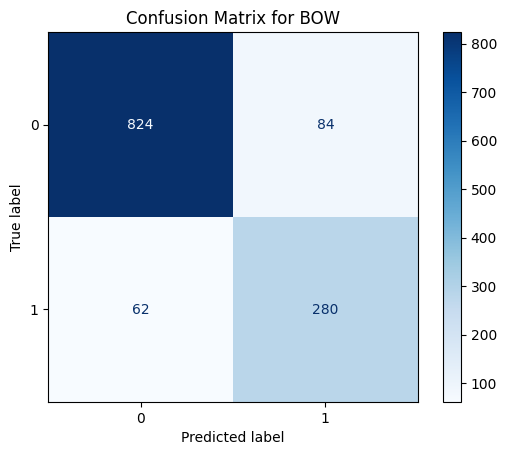

  Model  Train Accuracy  Train F1  Train Precision  Train Recall  \
0   BOW        0.963246  0.963435         0.958316      0.968608   

   Validation Accuracy  Validation F1  Validation Precision  Validation Recall  
0             0.925238       0.927513              0.900467           0.956235  


In [143]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
import numpy as np

# Function to evaluate model and plot confusion matrix
def evaluate_model_and_plot_confusion_matrix(model, X_train, y_train, X_val, y_val, model_name, cv=4):
    # Perform cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'f1', 'precision', 'recall'], return_estimator=True, return_train_score=True)
    
    # Select the best model from cross-validation based on validation accuracy
    best_model_idx = np.argmax(cv_results['test_accuracy'])
    best_model = cv_results['estimator'][best_model_idx]
    
    # Predictions on validation data
    y_val_pred = best_model.predict(X_val)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Evaluate performance
    return {
        'Model': model_name,
        'Train Accuracy': cv_results['train_accuracy'][best_model_idx],
        'Train F1': cv_results['train_f1'][best_model_idx],
        'Train Precision': cv_results['train_precision'][best_model_idx],
        'Train Recall': cv_results['train_recall'][best_model_idx],
        'Validation Accuracy': cv_results['test_accuracy'][best_model_idx],
        'Validation F1': cv_results['test_f1'][best_model_idx],
        'Validation Precision': cv_results['test_precision'][best_model_idx],
        'Validation Recall': cv_results['test_recall'][best_model_idx]
    }

# Dictionary of models
models = {
    'BOW': GradientBoostingClassifier(random_state=g_random_state, learning_rate=0.1, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=200),
}

# Features for each model
X_train_features = {
    'BOW': X_train_bow_over,
}

X_val_features = {
    'BOW': X_val_bow_over,
}

# Evaluate each model and store results
results = []
for model_name, model in models.items():
    metrics = evaluate_model_and_plot_confusion_matrix(model, X_train_features[model_name], y_train_over, X_val_features[model_name], y_val, model_name, cv=3)
    results.append(metrics)

# Create DataFrame
df_gbm = pd.DataFrame(results)
df_gbm = df_gbm[['Model', 'Train Accuracy', 'Train F1', 'Train Precision', 'Train Recall', 
                 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall']]

print(df_gbm)


<a class="anchor" id="topic09" /><br>
## 9. Evaluation on Test Set
[Back to Index](#index)

### 9.1 Initial Analysis

In [144]:
airbnb_df_test

,description,host_about
index,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
4,Charming Apartment Close to the Bay of Cascais...,:)
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...
...,...,...
691,Brand new apartment in a XVIcentury building! ...,"Hi, I'm Maria!_x000D_\nI work on cinema, tv, t..."
692,Located in one of the most iconic streets of L...,"Hi there!\n\nWe're GuestReady, a professional ..."
693,<b>The space</b><br />STUDIO <br /> <br />The ...,"Hello my name is Laetitia, which means ""joy"" i..."


In [145]:
airbnb_test_reviews

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...
...,...,...
41861,695,Everything was fine!
41862,695,Very good located
41863,695,Appartement confortable conforme aux photos bi...
41864,695,Très bon logement pour un week-end prolongé à ...


In [146]:
# Count the occurrences of each index in the 'index' column of airbnb_train_reviews
index_counts = airbnb_test_reviews['index'].value_counts()

# Map the index counts to a new column in airbnb_df_train and fill NaN values with 0
airbnb_df_test['reviews'] = airbnb_df_test.index.map(index_counts.get).fillna(0).astype(int)

In [147]:
airbnb_df_test.head()

,description,host_about,reviews
index,,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",125
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,11
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",0
4,Charming Apartment Close to the Bay of Cascais...,:),17
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,50


In [148]:
airbnb_df_test['language_d'] = airbnb_df_test['description'].apply(detect_language)
airbnb_df_test['language_d'].value_counts()

language_d
en    577
pt     95
da     10
fr      7
de      2
es      2
no      1
ca      1
Name: count, dtype: int64

In [152]:
languages_description_test = airbnb_df_test['language_d'].unique()

# Create stop words for each language
stopwords_by_language_description_test = {lang: create_stopwords(lang) for lang in languages_description_test}

print(stopwords_by_language_description_test['en'])

{'hasn', 'were', 'than', 'will', 'above', 'where', 'herself', "hasn't", 'y', 's', "you've", 'up', 'itself', 'me', 'ourselves', 'more', 'haven', 'needn', 'mightn', "needn't", 'll', 'do', "that'll", "should've", 'should', 'his', 'against', 'doesn', 'of', 'when', "wasn't", 'what', 'have', 'and', 'to', 'while', 'be', 'an', 'we', 'she', 'so', 'few', 'that', 'those', 'but', 'm', 'shouldn', "wouldn't", 'whom', 'by', 'he', 'further', 'very', 'hers', 'hadn', 'myself', "haven't", 'these', "isn't", "doesn't", 'weren', 'which', 'won', 'this', 'being', 'was', "you're", 'can', 'them', 'before', 'theirs', 'some', 'their', 'ma', 'are', "shouldn't", 'has', 'such', 'most', 're', 'd', 'on', 'shan', "aren't", "weren't", 'there', 'all', 'why', 'not', "hadn't", 'just', 'ain', 'nor', 'in', 'through', 'too', 'until', 'with', "mustn't", 'did', 'over', 'now', 'a', 'out', 'its', 'wasn', 'i', 'had', 'our', 'only', 'your', 'my', 'or', 'having', "couldn't", 'after', "don't", 'you', 'been', 'both', 'from', 'at', 'in

In [154]:
airbnb_df_test['language_ha'] = airbnb_df_test['host_about'].apply(detect_language)
airbnb_df_test['language_ha'].value_counts()

language_ha
en       503
pt       135
fr        17
es         8
de         5
it         4
nl         3
ca         2
tl         1
et         1
cs         1
no         1
id         1
ru         1
he         1
zh-cn      1
Name: count, dtype: int64

In [155]:
languages_host_about_test = airbnb_df_test['language_ha'].unique()

# Create stop words for each language
stopwords_by_language_host_about_test = {lang: create_stopwords(lang) for lang in languages_host_about_test}

print(stopwords_by_language_host_about_test['en'])

{'hasn', 'were', 'than', 'will', 'above', 'where', 'herself', "hasn't", 'y', 's', "you've", 'up', 'itself', 'me', 'ourselves', 'more', 'haven', 'needn', 'mightn', "needn't", 'll', 'do', "that'll", "should've", 'should', 'his', 'against', 'doesn', 'of', 'when', "wasn't", 'what', 'have', 'and', 'to', 'while', 'be', 'an', 'we', 'she', 'so', 'few', 'that', 'those', 'but', 'm', 'shouldn', "wouldn't", 'whom', 'by', 'he', 'further', 'very', 'hers', 'hadn', 'myself', "haven't", 'these', "isn't", "doesn't", 'weren', 'which', 'won', 'this', 'being', 'was', "you're", 'can', 'them', 'before', 'theirs', 'some', 'their', 'ma', 'are', "shouldn't", 'has', 'such', 'most', 're', 'd', 'on', 'shan', "aren't", "weren't", 'there', 'all', 'why', 'not', "hadn't", 'just', 'ain', 'nor', 'in', 'through', 'too', 'until', 'with', "mustn't", 'did', 'over', 'now', 'a', 'out', 'its', 'wasn', 'i', 'had', 'our', 'only', 'your', 'my', 'or', 'having', "couldn't", 'after', "don't", 'you', 'been', 'both', 'from', 'at', 'in

### 9.2 Lowercase

In [156]:
# description column
airbnb_df_test['description'] = airbnb_df_test['description'].apply(lambda x: " ".join(word.lower() for word in x.split()))

# host_about column
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].apply(lambda x: " ".join(word.lower() for word in x.split()))

airbnb_df_test.head()

,description,host_about,reviews,language_d,language_ha
index,,,,,
1,<b>the space</b><br />apartment located in the...,"gosto de viajar, de conhecer pessoas, gosto de...",125,en,pt
2,"important: in response to covid-19, this prope...",we are the be@home team! you can count on us t...,11,en,en
3,"bright, beautiful, and spacious. this four-bed...","hi there! we're guestready, a professional pro...",0,en,en
4,charming apartment close to the bay of cascais...,:),17,en,None
5,"se procura umas férias perto da praia, casino ...",bem vindos a portugal!_x000d_ adoro o meu país...,50,pt,pt


### 9.3 HTML Tags

In [157]:
def remove_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator=' ')
    return clean_text

airbnb_df_test['description'] = airbnb_df_test['description'].apply(remove_tags)
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].apply(remove_tags)

airbnb_df_test.head()

,description,host_about,reviews,language_d,language_ha
index,,,,,
1,the space apartment located in the historic ce...,"gosto de viajar, de conhecer pessoas, gosto de...",125,en,pt
2,"important: in response to covid-19, this prope...",we are the be@home team! you can count on us t...,11,en,en
3,"bright, beautiful, and spacious. this four-bed...","hi there! we're guestready, a professional pro...",0,en,en
4,charming apartment close to the bay of cascais...,:),17,en,None
5,"se procura umas férias perto da praia, casino ...",bem vindos a portugal!_x000d_ adoro o meu país...,50,pt,pt


### 9.4 Regular Expressions

In [159]:
# Define the replacement dictionary
replacement_dict = {
    r'License number': 'license',
    r'Alojamento Local Registro': 'alojamento',
    r'_x000d_': ''
}

def update_regex(text, replacement_dict):
    # Apply regular expressions to replace specific patterns
    for pattern, replacement in replacement_dict.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    return text

# Apply the updated function to the specified columns in each DataFrame
airbnb_df_test['description'] = airbnb_df_test['description'].apply(lambda x: update_regex(x, replacement_dict))
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].apply(lambda x: update_regex(x, replacement_dict))

airbnb_df_test.head()

,description,host_about,reviews,language_d,language_ha
index,,,,,
1,the space apartment located in the historic ce...,"gosto de viajar, de conhecer pessoas, gosto de...",125,en,pt
2,"important: in response to covid-19, this prope...",we are the be@home team! you can count on us t...,11,en,en
3,"bright, beautiful, and spacious. this four-bed...","hi there! we're guestready, a professional pro...",0,en,en
4,charming apartment close to the bay of cascais...,:),17,en,None
5,"se procura umas férias perto da praia, casino ...","bem vindos a portugal! adoro o meu país, mas t...",50,pt,pt


### 9.5 Symbols

In [160]:
def remove_symbols(text):
    symbols_to_remove = ["▲", "☼", "★", "»", "💯"]  
    for symbol in symbols_to_remove:
        text = text.replace(symbol, "")
    return text

# Apply the function to the 'description' and 'host_about' columns
airbnb_df_test['description'] = airbnb_df_test['description'].apply(remove_symbols)
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].apply(remove_symbols)

airbnb_df_test.head()

,description,host_about,reviews,language_d,language_ha
index,,,,,
1,the space apartment located in the historic ce...,"gosto de viajar, de conhecer pessoas, gosto de...",125,en,pt
2,"important: in response to covid-19, this prope...",we are the be@home team! you can count on us t...,11,en,en
3,"bright, beautiful, and spacious. this four-bed...","hi there! we're guestready, a professional pro...",0,en,en
4,charming apartment close to the bay of cascais...,:),17,en,None
5,"se procura umas férias perto da praia, casino ...","bem vindos a portugal! adoro o meu país, mas t...",50,pt,pt


### 9.6 Contractions

In [161]:
def expand_contractions(text):
    # Expand contractions
    expanded_text = contractions.fix(text)
    return expanded_text

airbnb_df_test['description'] = airbnb_df_test['description'].apply(expand_contractions)
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].apply(expand_contractions)

airbnb_df_test.head()

,description,host_about,reviews,language_d,language_ha
index,,,,,
1,the space apartment located in the historic ce...,"gosto de viajar, de conhecer pessoas, gosto de...",125,en,pt
2,"important: in response to covid-19, this prope...",we are the be@home team! you can count on us t...,11,en,en
3,"bright, beautiful, and spacious. this four-bed...","hi there! we are guestready, a professional pr...",0,en,en
4,charming apartment close to the bay of cascais...,:),17,en,None
5,"se procura umas férias perto da praia, casino ...","bem vindos a portugal! adoro o meu país, mas t...",50,pt,pt


### 9.7 Punctuation

In [162]:
def remove_punctuation(input_string):
    # Define the set of punctuation characters
    exclude = set(string.punctuation)
    # Use a list comprehension to filter out punctuation characters
    filtered_string = ''.join(char for char in input_string if char not in exclude)
    
    return filtered_string

airbnb_df_test['description'] = airbnb_df_test['description'].apply(remove_punctuation)
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].apply(remove_punctuation)

airbnb_df_test.head()

,description,host_about,reviews,language_d,language_ha
index,,,,,
1,the space apartment located in the historic ce...,gosto de viajar de conhecer pessoas gosto de r...,125,en,pt
2,important in response to covid19 this property...,we are the behome team you can count on us to ...,11,en,en
3,bright beautiful and spacious this fourbedroom...,hi there we are guestready a professional prop...,0,en,en
4,charming apartment close to the bay of cascais...,,17,en,None
5,se procura umas férias perto da praia casino e...,bem vindos a portugal adoro o meu país mas tam...,50,pt,pt


### 9.8 Handle Numbers

In [163]:
def replace_numbers(text):
    # Replace numbers with '#NUMBER'
    text = re.sub(r'\b\d+\b', 'number', text)
    # Replace 'ALOJAMENTOLOCAL' followed by digits and optionally followed by 'al' with '#ALOJAMENTOLOCAL'
    text = re.sub(r'ALOJAMENTOLOCAL\s*\d+al', 'alojamentolocal', text)
    # Replace numbers followed by a word or unit with 'NUMBER<unit>'
    text = re.sub(r'\b(\d+)([a-zA-Z]+(?:\^2)?)\b', r'number\2', text)
    
    return text


airbnb_df_test['description'] = airbnb_df_test['description'].apply(replace_numbers)
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].apply(replace_numbers)

airbnb_df_test.head()

,description,host_about,reviews,language_d,language_ha
index,,,,,
1,the space apartment located in the historic ce...,gosto de viajar de conhecer pessoas gosto de r...,125,en,pt
2,important in response to covid19 this property...,we are the behome team you can count on us to ...,11,en,en
3,bright beautiful and spacious this fourbedroom...,hi there we are guestready a professional prop...,0,en,en
4,charming apartment close to the bay of cascais...,,17,en,None
5,se procura umas férias perto da praia casino e...,bem vindos a portugal adoro o meu país mas tam...,50,pt,pt


### 9.9 WordNinja

In [164]:
import wordninja
import pandas as pd

# Define a function to correct text using wordninja
def correct_text(text):
    return ' '.join(wordninja.split(text))

# Apply the correction to the dataframe
airbnb_df_test['description'] = airbnb_df_test.apply(
    lambda row: correct_text(row['description']) if row['language_d'] == 'en' else row['description'], axis=1
)

airbnb_df_test['host_about'] = airbnb_df_test.apply(
    lambda row: correct_text(row['host_about']) if row['language_ha'] == 'en' else row['host_about'], axis=1
)


### 9.10 Stopwords

In [165]:
def remove_stopwords(text, stopwords):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords]
    return ' '.join(filtered_tokens)

# Remove stop words from description based on language
for lang in airbnb_df_test['language_d'].dropna().unique():
    stopwords = stopwords_by_language_description_test.get(lang, [])
    airbnb_df_test.loc[airbnb_df_test['language_d'] == lang, 'description'] = airbnb_df_test[airbnb_df_test['language_d'] == lang]['description'].apply(lambda x: remove_stopwords(x, stopwords))

# Remove stop words from host_about based on language
for lang in airbnb_df_test['language_ha'].dropna().unique():
    stopwords = stopwords_by_language_host_about_test.get(lang, [])
    airbnb_df_test.loc[airbnb_df_test['language_ha'] == lang, 'host_about'] = airbnb_df_test[airbnb_df_test['language_ha'] == lang]['host_about'].apply(lambda x: remove_stopwords(x, stopwords))


airbnb_df_test.head()    

,description,host_about,reviews,language_d,language_ha
index,,,,,
1,space apartment located historic center lisbon...,gosto viajar conhecer pessoas gosto receber am...,125,en,pt
2,important response c ovid 19 property extended...,home team count us take care every single deta...,11,en,en
3,bright beautiful spacious four bedroom apartme...,hi guest ready professional property managemen...,0,en,en
4,charming apartment close bay casca number bedr...,,17,en,None
5,procura umas férias perto praia casino outras ...,bem vindos portugal adoro país adoro conhecer ...,50,pt,pt


### 9.11 lemmatize

In [166]:
nlp = spacy.load("en_core_web_sm")
# Function to lemmatize text using SpaCy with custom handling
def spacy_lemmatize(text):
    # Preprocess the text
    text = preprocess_text(text)
    # Process the text with SpaCy
    doc = nlp(text)
    # Lemmatize each token with custom handling
    lemmatized_text = ' '.join([custom_lemmatize(token.text) if token.text in custom_lemma else token.lemma_ for token in doc])
    return lemmatized_text

# Apply the spacy_lemmatize function to each column
airbnb_df_test['description'] = airbnb_df_test['description'].apply(spacy_lemmatize)
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].apply(spacy_lemmatize)

airbnb_df_test.head()

,description,host_about,reviews,language_d,language_ha
index,,,,,
1,space apartment locate historic center lisbon ...,gosto viajar conhecer pessoas gosto receber am...,125,en,pt
2,important response c ovid 19 property extend c...,home team count we take care every single deta...,11,en,en
3,bright beautiful spacious four bedroom apartme...,hi guest ready professional property managemen...,0,en,en
4,charming apartment close bay casca number bedr...,,17,en,None
5,procura umas férias perto praia casino outra a...,bem vindos portugal adoro país adoro conhecer ...,50,pt,pt


### 9.12 Num_column(reviews)

In [167]:
X_test_num = scaler.transform(airbnb_df_test[['reviews']])

### 9.13 BOW

In [168]:
X_test_bow = bow.transform(airbnb_df_test[['description', 'host_about']].apply(lambda x: ' '.join(x), axis=1))

X_test_bow = hstack([X_test_bow, X_test_num])

### 9.14 Test Model

In [171]:
best_model = GradientBoostingClassifier(learning_rate=0.1,
                                   max_depth=7,
                                   min_samples_leaf=4,
                                   min_samples_split=5,
                                   n_estimators=200,
                                   random_state=g_random_state,
                                   verbose=False)

In [172]:
best_model.fit(X_train_bow_over, y_train_over)

GradientBoostingClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=5,
                           n_estimators=200, random_state=53, verbose=False)

In [175]:
final_predictions = best_model.predict(X_test_bow)
final_predictions

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,

In [176]:
answer = pd.DataFrame([airbnb_df_test.index.T, final_predictions]).T
answer.columns = ['index','unlisted']
answer

,index,unlisted
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
...,...,...
690,691,0
691,692,0
692,693,0
693,694,0


### 9.15 Convert to CSV

In [214]:
answer.to_csv('PredictionsNLP.csv', index = None)